In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import shutil, os, random, gc, time, traceback
import numpy as np
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from keras import backend as K

from keras.applications import InceptionV3, VGG16, ResNet50, InceptionResNetV2, DenseNet201

from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Conv2D, Flatten, Activation, Dropout, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, GlobalMaxPooling2D
from keras.losses import binary_crossentropy, categorical_crossentropy

import cache_magic
%matplotlib inline

Using TensorFlow backend.


In [2]:
pd.options.display.float_format = "{:,.2f}".format

DATA_PATH = './data/'
MODEL_PATH = './model'

# DeepFashion: Versión reducida

En este notebook se realiza la comparativa entre un único modelo multietiqueta y un modelo compuesto por sub-modelos por tipo de atributo. 

Se emplea la versión reducida del conjunto de datos de DeepFashion. En análisis descriptivo de este conjunto de datos se realiza en un [Notebook anexo](./DeepFashion_VersionReducida_Analisis.ipynb). También se ha realizado [el mismo análisis](./DeepFashion_VersionCompleta_Analisis.ipynb) de la versión completa del dataset.

Para el particionado de datos en los conjuntos de entrenamiento, validación y test se emplean las particiones proporcionadas junto con el conjunto de datos. En el análisis mencionado anteriormente se ha podido comprobar que la proporción de cada uno de los atributos es similar en las tres particiones. 

El principal problema de este conjunto es el _data imbalance_. Dentro de cualquiera de los seis tipos de atributo existen atributos que aparecen con mucha más frecuencia que otros. Por ejemplo, en la partición de test y dentro de los tipos de tejido, _cotton_ aparece 2736 veces mientras que _faux_ aparece únicamente 46 por lo que será muy difícil que los modelos aprendan características de este tipo de atributo. 

In [3]:
# Constantes

# Rutas a directorios de datos
ANNO_FINE_PATH = DATA_PATH + 'anno_fine'
TRAIN_PATH = ANNO_FINE_PATH + '/train'
VALIDATION_PATH = ANNO_FINE_PATH + '/val'
TEST_PATH = ANNO_FINE_PATH + '/test'
AUGMENTED_DATA_PATH = ANNO_FINE_PATH + '/augmented'
IMG = DATA_PATH + 'img'

# Rutas a ficheros de datos
ATTR_CLOTH_LIST_FILE = ANNO_FINE_PATH + '/list_attr_cloth.txt'
ATTR_IMG_LIST_FILE = ANNO_FINE_PATH + '/list_attr_img.txt'

# Constantes relativas al conjunto de datos
ATTR_TYPES = {'1':"Estampado",'2':"Tipo de manga",'3':"Forma",'4':"Tipo de cuello",'5':"Tejido",'6':"Tallaje"}
NUM_CLASSES = 26 


## 1. Lectura y preprocesado de datos

En primer lugar se crea una serie de estructuras de datos auxiliares para facilitar el trabajo con el dataset entre las que se incluye:
* __column_to_attr_name__: Mapping de número de columna a nombre de atributo 
* __attr_type_to_columns__: Mapping del tipo de atributo hacia las columnas que pertenecen a atributos de ese tipo.
* __attributes__: Listado de atributos en el orden en el que aparecen en el conjunto de datos.

In [4]:
# Lectura de la lista de atributos (fichero list_attr_cloth.txt)
def read_attr_cloth_list():
    column_to_attr_name = {}
    attr_type_to_columns = {}
    
    with open(ATTR_CLOTH_LIST_FILE) as fp: 
        fp.readline() # Ingorar numero de etiquetas
        fp.readline() # Ignorar cabecera
        column = 0
        for line in fp: 
            fields = line.split()
            attr = fields[0]
            attr_type = fields[1]
            column_to_attr_name[column] = attr
            if attr_type in attr_type_to_columns:
                attr_type_to_columns[attr_type].append(column)
            else:
                attr_type_to_columns[attr_type] = [column]
            column += 1
    return column_to_attr_name, attr_type_to_columns

In [5]:
# column_to_attr_name: Mapping número columna -> Nombre de atributo
# attr_type_to_columns: Mapping tipo de atributo - Lista de columnas de atributos de dicho tipo
column_to_attr_name, attr_type_to_columns = read_attr_cloth_list()           
# Listado con los nombre de los atributos
attributes = list(column_to_attr_name.values())

Copiamos los datos a una estructura de directorios con la que sea sencillo trabajar. Extraemos las imágenes que forman parte de cada una de las paticiones, y las copiamos en un directorio con el nombre de la partición (test, val, train):

In [6]:
# Devuelve el listado de imágnes del fichero recibido como parámetro
def read_image_list(file_name):
    file_path = ANNO_FINE_PATH + '/' + file_name + '.txt'
    with open(file_path) as fp:
        return [DATA_PATH + img.rstrip('\n') for img in fp]
    
# Devuelve el path de la partición a partir del nombre de la partición
def build_partition_data_path(partition):
    return ANNO_FINE_PATH + '/' + partition

# Creación de la estructura de datos necesaria para los generadores de aumentación de datos
def create_data_structure(force=False):
    for partition in ['test', 'train', 'val']:
        partition_data_path = build_partition_data_path(partition)
        
        # Forzar recarga
        if os.path.exists(partition_data_path) and force:
            shutil.rmtree(partition_data_path)
        
        if not os.path.exists(partition_data_path):
            os.mkdir(partition_data_path)
            # Carga del listado de imágenes
            image_list = read_image_list(partition)
            # Copia
            for i, src in enumerate(image_list):
                dst = partition_data_path + '/' + str(i) + '.jpg' 
                shutil.copyfile(src, dst)


In [7]:
create_data_structure(False)

## 2. Aumentación de datos

A continuación se define la función que crea los generadores de imágenes que realizan las transformaciones de data augmentation de forma dinámica a la hora de realizar el entrenamiento de los modelos. Se han configurado de forma que las imagenes generadas se almacenen en el directorio definidos por la constante AUGMENTED_DATA_PATH para poder ser inspeccionados. 

La función es parametrizable para poder realizar un análisis de los valores óptimos y elegir los más adecuados para esta tarea de clasificación. Este análisis se realiza más adelante.

In [8]:
# Construcción del dataframe requerido para usar la función flow_from_dataframe
# En el caso de no pasarle attr_type, tiene en cuenta todos los atributos (empleado en la versión con un único modelo)
# En caso contrario, filtra los atributos pertenecientes al tipo pasado por parámetro. (empleado en la versión de un modelo por
# tipo de atributo)
def build_iterator_dataframe(partition, attr_type=None):
    partition_attribute_filepath = ANNO_FINE_PATH + "/" + partition + "_attr.txt"
    data = pd.read_csv(partition_attribute_filepath, sep = ' ', names = attributes, index_col=False)
    
    # Filtrado por tipo de atributo. Empleado para los clasificadores separados por tipo de atributo. 
    if attr_type is not None:
        columns = attr_type_to_columns[str(attr_type)]
        fst, lst = columns[0], columns[-1]+1
        data = data.iloc[:, fst:lst]
    
    if 'filename' not in data.columns:
        data['filename'] = [str(i) + '.jpg' for i in range(0,len(data))]
    return data

In [9]:
# Devuelve los nombres de los atributos pertenecientes al tipo de atributo pasado por parámetro
def get_attributes_for_attribute_type(attr_type):
    if attr_type is None:
        return attributes
    else:
        return [column_to_attr_name[c] for c in attr_type_to_columns[str(attr_type)]]

In [10]:
SEED = 1
BATCH_SIZE = 4


# Construcción del generador de datos de entrenamiento
def build_train_datagen(shear_range=0.025, zoom_range=0.025, rotation_range=2.5, fill_mode='nearest'):
    return ImageDataGenerator(
        rescale=1/255.0,
        shear_range=shear_range,
        zoom_range=zoom_range,
        rotation_range=rotation_range,
        fill_mode = fill_mode,
        horizontal_flip=True)

# Construcción de los generadores de datos de entrenamiento y validación
def build_generators(img_size, shear_range, zoom_range, rotation_range, fill_mode, attr_type = None):
        
    # Borrar los directorios con las imagenes generadas
    if os.path.exists(AUGMENTED_DATA_PATH):
        shutil.rmtree(AUGMENTED_DATA_PATH)
    os.mkdir(AUGMENTED_DATA_PATH)
    
    # Generator de entrenamiento
    train_datagen = build_train_datagen(shear_range, zoom_range, rotation_range, fill_mode)
    train_generator = train_datagen.flow_from_dataframe(
        dataframe = build_iterator_dataframe('train', attr_type),
        x_col="filename",
        y_col=get_attributes_for_attribute_type(attr_type),
        directory=TRAIN_PATH,
        target_size=(img_size,img_size),
        batch_size=BATCH_SIZE,
        class_mode='raw',
        color_mode='rgb',
        seed=SEED,
        save_to_dir=AUGMENTED_DATA_PATH
    )
    
    print(TRAIN_PATH)

    # Generator de validación
    validation_datagen = ImageDataGenerator(
         rescale=1./255
    )

    validation_generator = validation_datagen.flow_from_dataframe(
        dataframe=build_iterator_dataframe('val', attr_type),
        x_col="filename",
        y_col=get_attributes_for_attribute_type(attr_type),
        directory=VALIDATION_PATH,
        target_size=(img_size,img_size),
        #batch_size=BATCH_SIZE,
        class_mode='raw',
        color_mode='rgb',
        seed=SEED
    )
    
    return train_generator, validation_generator


# Construcción del generador de datos de test
def build_test_generator(img_size=224, attr_type = None):
        
    test_datagen = ImageDataGenerator(
         rescale=1./255
    )
    
    test_generator = test_datagen.flow_from_dataframe(
        dataframe=build_iterator_dataframe('test', attr_type),
        x_col="filename",
        y_col=get_attributes_for_attribute_type(attr_type),        
        directory=TEST_PATH,
        target_size=(img_size,img_size),
       # batch_size=BATCH_SIZE,
        class_mode=None,
        color_mode='rgb',
        seed=SEED,
        shuffle=False
    )
    
    return test_generator 

Para validar visualmente las transformaciones realizadas, el siguiente código elige de forma aleatoria una imagen de la partición de test y muestra 9 imagenes alteradas generadas con el código definido anteriormente. 

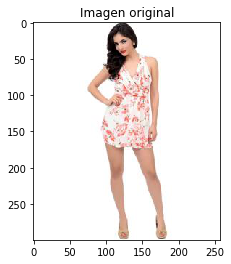

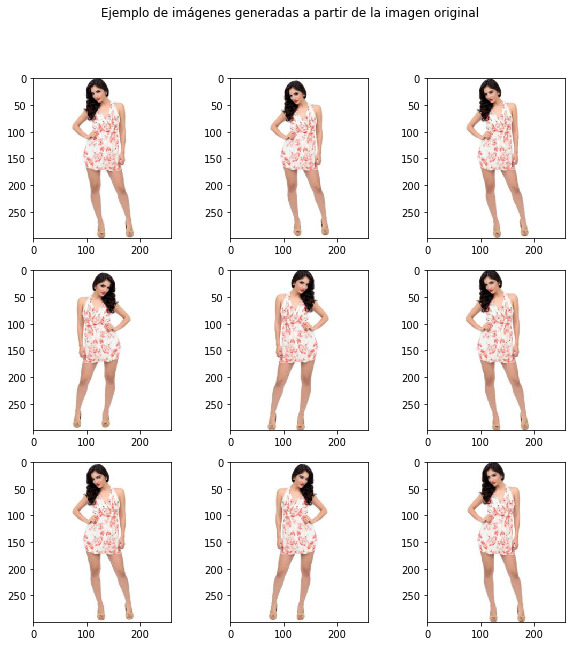

In [11]:
# Carga de una imagen aleatoria
path = ANNO_FINE_PATH + '/test'
file = random.choice(os.listdir(path))
img = load_img('{}/{}'.format(path, file))

plt.title('Imagen original')
plt.imshow(img)
plt.show()

# Preprocesado y preparación del iterador
data = img_to_array(img)
samples = np.expand_dims(data, 0)

generator = build_train_datagen()
it = generator.flow(samples, batch_size=1)

# Generación de 9 imágenes a partir de la imagen original
fig, axs = plt.subplots(3, 3, figsize=(10, 10))
fig.suptitle('Ejemplo de imágenes generadas a partir de la imagen original')
for x in range(9):
    batch = it.next()
    axs[x//3,x%3].imshow(batch[0], cmap='gray')
plt.show()

## 3. Automatización

Dado que se va a realizar el entrenamiento de un gran número de modelos y el tiempo para la realización del proyecto es limitado, se realiza una automatización de todo el proceso para poder probar distintos modelos de forma flexible, y minimizando el tiempo de interacción con el notebook para realizar el entrenamiento, y así maximizar el aprovechamiento del tiempo disponible. 

Para poder probar distintos modelos de forma simple se define una función **_train_** que encapsula todo el código necesario para realizar el entrenamiento (limpieza de sesiones anteriores, instanciación del modelo y generadores de datos, etc...) 

Cabe destacar que se llama a la función fit con tres callbacks:
- Checkpoint, para persistir el modelo que minimiza el loss y poder ser empleado más adelante, en los casos en los que un modelo empiece a sobreajustar a los datos de entrenamiento. 
- Reducción de learning rate en el caso de que en N iteraciones seguidas el modelo no mejore. Viene definido por la constante LR_REDUCTION_PATIENCE. 
- Early stopping, para realizar la parada del entrenamiento en el caso de que no se consiga una mejora ni reduciendo la velocidad de aprendizaje. Viene definido por la constante EARLY_STOPPING_PATIENCE. 

Nótese que la función **_train_** requiere de dos parámetros obligatorios: model_name y model_id. Es primero es necesario porque, para realizar la instanciación del modelo se realiza una llamada una función con nombre **_build\_{model\_name}_**. El segundo parámetro es empleado a la hora de generar el nombre con el que persiste un modelo (**_model\_name\_model\_id.h5}_**) para poder persistir distintas versiones de un mismo tipo de modelo. Incluye un tercer parámetro (attr_type), obligatorio en los casos en los que se quiera hacer el entrenamiento de un modelo para un tipo de atributo en particular. Este campo toma valores del 1 al 6, basado en la constante ATTR_TYPES.

Esto permite que el código sea genérico y baste con definir una función **_build\_{model\_name}_** para poder entrenar y validar un modelo nuevo. 

Por otro lado, toma como parámetro la función de loss a emplear, y *model_build_params*, un diccionario con el que se le puede pasar valores de parámetros a las funciones de construcción de modelos. 

Finalmente, se definen también los parámetros de data augmentatio, configurados con los valores por defecto con los que se consiguen los mejores resultados (ver apartado 4.2).

In [12]:
# Definición de la función de loss empleada por defecto. 
# Detallado en la sección "Selección de función de loss"

import tensorflow as tf
import keras.backend.tensorflow_backend as tfb

POS_WEIGHT = 10  # multiplier for positive targets, needs to be tuned

def weighted_binary_crossentropy(target, output):
    """
    Weighted binary crossentropy between an output tensor 
    and a target tensor. POS_WEIGHT is used as a multiplier 
    for the positive targets.

    Combination of the following functions:
    * keras.losses.binary_crossentropy
    * keras.backend.tensorflow_backend.binary_crossentropy
    * tf.nn.weighted_cross_entropy_with_logits
    """
    # transform back to logits
    _epsilon = tfb._to_tensor(tfb.epsilon(), output.dtype.base_dtype)
    output = tf.clip_by_value(output, _epsilon, 1 - _epsilon)
    output = tf.math.log(output / (1 - output))
    # compute weighted loss
    loss = tf.nn.weighted_cross_entropy_with_logits(labels=target,
                                                    logits=output,
                                                    pos_weight=POS_WEIGHT)
    return tf.reduce_mean(loss, axis=-1)

In [13]:
EARLY_STOPPING_PATIENCE = 8
LR_REDUCTION_PATIENCE = 4

# Conversión del tamaño de la imagen al shape esperado como input del modelo
def to_input_shape(img_size):
    return (img_size,img_size,3)

# Construcción del path donde se persiste el modelo
def to_model_path(model_name, model_id, attr_type = None):
    if not os.path.exists(MODEL_PATH):
        os.mkdir(MODEL_PATH)
    if attr_type is None:
        return '{}/{}_{}.h5'.format(MODEL_PATH, model_name, model_id)
    else:
        return '{}/{}_{}_{}.h5'.format(MODEL_PATH, model_name, model_id, attr_type)

# Construcción del nombre de la función de instanciación de un modelo
def to_build_function(model_name):
    return 'build_' + model_name

# Desactiva el entrenamiento del X% de capas iniciales. 
def freeze_layers(model, ratio=0.5):
    n_layers = len(model.layers)
    last_layer_to_freeze = int(n_layers*ratio)
    
    for layer in model.layers[:last_layer_to_freeze]:
        layer.trainable = False
    for layer in model.layers[last_layer_to_freeze:]:
        layer.trainable = True
    
    return model

def build_callbacks(model_name, model_id, store_model, attr_type):
    callbacks = []
    # Parar la ejecución si el loss no disminuye en 3 iteraciones
    early_stopping = EarlyStopping(monitor='val_loss', patience=EARLY_STOPPING_PATIENCE, verbose=1, min_delta=1e-4)
    callbacks.append(early_stopping)
    # Reducir el learning rate si el loss no disminuye en 3 iteraciones
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=LR_REDUCTION_PATIENCE, verbose=1, min_delta=1e-4)  
    callbacks.append(reduce_lr)
    # Guardar el modelo que más disminuye el loss en fichero
    if store_model:
        checkpoint = ModelCheckpoint(filepath = to_model_path(model_name, model_id, attr_type), 
                                     monitor='val_auc', verbose=1, save_best_only=True, mode='max')
        callbacks.append(checkpoint)
    return callbacks

# Entrenamiento, y todo el pre-procesamiento necesario. 
def train(model_name,
          model_id=None,
          max_epochs=100, 
          img_size=224,
          shear_range=0.05, 
          zoom_range=0.150, 
          rotation_range=2.5, 
          fill_mode='constant',
          store_model=True,
          two_step_fit=False,
          freeze_layers_ratio=None,
          model_build_params=None,
          loss_function=binary_crossentropy,
          attr_type=None,
          class_weight = None
         ):
    
    # Forzar limpieza y pasar el GC
    K.clear_session()
    #cuda.select_device(0)
    #cuda.close()
    gc.collect()
    
    # Instanciación del modelo. Todos los métodos siguen el patrón "build_xxx", donde xxx es esl nombre del modelo
    input_shape = to_input_shape(img_size)
    model = globals()[to_build_function(model_name)](input_shape, model_build_params)
    #model.summary()
    
    # COMPILE con run options para debug en caso de oom
    #run_opts = tf.compat.v1.RunOptions(report_tensor_allocations_upon_oom = True)
    # model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.compile(optimizer='adam', loss=loss_function, metrics=[tf.keras.metrics.AUC(name='auc'), 'accuracy'])
    
    # Instanciación de los generators de datos
    train_generator, validation_generator = build_generators(img_size, shear_range, 
                                                             zoom_range, rotation_range, fill_mode, attr_type)
    
    
    
    # FIT
    # Basado en el parámetro two_step_fit, se permite un único entrenamiento, o un entrenamiento en dos fases: una primera fase
    # en la que se ajusta primero las últimas capas densas, y un segundo paso en el que se ajusta el resto de capas no congeladas.
    # En el caso de emplear el entrenamiento en dos fases, la función build ha de congelar todas las capas exceptuando las densas
    # de la parte final de la red.
    if two_step_fit:
        h = model.fit_generator(train_generator, validation_data=validation_generator, 
                                epochs=max_epochs, callbacks = build_callbacks(model_name, model_id, False, attr_type),
                                steps_per_epoch=50,
                                validation_steps=10
                               )
        # Segunda fase de training para entrenar el resto de las capas
        model = freeze_layers(model, freeze_layers_ratio)
        model.compile(optimizer='adam', loss=loss_function, metrics=[tf.keras.metrics.AUC(name='auc'), 'accuracy'])
        h = model.fit_generator(train_generator, validation_data=validation_generator, 
                                epochs=max_epochs, callbacks = build_callbacks(model_name, model_id, store_model, attr_type),
                                steps_per_epoch=50,
                                validation_steps=10,
                                class_weight=class_weight
                               )
    else:
        h = model.fit_generator(train_generator, validation_data=validation_generator, 
                                epochs=max_epochs, callbacks = build_callbacks(model_name, model_id, store_model, attr_type),
                                steps_per_epoch=50,
                                validation_steps=10,
                                class_weight=class_weight
                               )
    
    return (h.history['val_loss'], h.history['val_accuracy'], h.history['val_auc'])

El siguiente fragmento de código automatiza la creación y entrenamiento de varias versiones de un mismo modelo y devuelve un Dataframe con los resultados. 

La búsqueda de los parámetros se realiza de forma aleatoria. Los parámetros variables son:
* Tipo de pooling (max, avg, sin pooling)
* Tamaño de la capa densa final
* Porcentaje de capas que se mantienen congeladas (es decir, que se mantienen con los valores iniciales sin reentrenar). 

El entrenamiento se realiza en dos pasos:
1. Se congelan todas las capas del modelo pre-entrenado para entrenar únicamente las capas densas añadidas en la parte final de la red.
2. Se descongela un porcentaje de las últimas capas del modelo pre-entrenado y se repite el entrenamiento.

Todos los modelos entrenados se persisten junto a un ID para poder ser recuperados posteriormente en el apartado de evaluación. 

In [14]:
KERNEL_SIZE_PARAM = "kernel_size"
DROPOUT_PARAM = "dropout"
GLOBAL_POOLING_TYPE = "global_pooling_type"
DENSE_LAYER_SIZE_PARAM = 'dense_layer_size'
NUM_BLOCKS_PARAM = "num_blocks"
FIRST_CONV_LAYER_SIZE = "first_conv_layer_size"
ACTIVATION_FUNCTION = "activation_function"
OUTPUT_LAYER_SIZE = "output_layer_size"

N = 20

def freeze_all_layers(model):
    for layer in model.layers:
        layer.trainable = False

def try_pretrained_model(model_name, 
                         attr_type=None, 
                         activation_function = 'sigmoid', 
                         loss_function = binary_crossentropy,
                         output_layer_size = NUM_CLASSES):
    results = pd.DataFrame(columns = [GLOBAL_POOLING_TYPE, DENSE_LAYER_SIZE_PARAM, 'freeze_layers_ratio', 'val_loss', 'val_acc', 'val_auc', 'time'])
    for i in range(0, N):
        try:
            # Random search de los parámetros
            params = {}
            params[GLOBAL_POOLING_TYPE] = random.choice(['avg', 'max', None])
            params[DENSE_LAYER_SIZE_PARAM] = random.randrange(128,513,8)
            freeze_layers_ratio = random.choice([0.5, 0.6, 0.7, 0.8])
            
            # Definición de la función de activación para usar en la capa de salida
            params[ACTIVATION_FUNCTION] = activation_function
            params[OUTPUT_LAYER_SIZE] = output_layer_size
            
            print('Evaluation #{}'.format(i))
            start = time.time()
            
            # Llamada a la función de entrenamiento definida en apartados anteriores
            (val_loss,  val_acc, val_auc) = train(model_name, i, store_model=True, two_step_fit=True, 
                                        freeze_layers_ratio=freeze_layers_ratio, model_build_params=params, 
                                        attr_type=attr_type, loss_function=loss_function)
            end = time.time() - start
            
            # Acumulación de los resultados
            results.loc[i] = [params[GLOBAL_POOLING_TYPE], params[DENSE_LAYER_SIZE_PARAM], freeze_layers_ratio, val_loss, val_acc, val_auc, end]
        except Exception as e:
            traceback.print_exc()
            print('Error: {}'.format(e))
            print('Error with params: {}'.format(params))
    return results

In [15]:
# Utilidad para mostrar métricas
def plot(results, metric, legend_loc = 'upper right'):
    legend = []
    fig = plt.figure(figsize=(15,10))
    for k,v in results.items():
        plt.plot(v)
        legend.append(k)
    plt.title('Comparativa de ' + metric)
    plt.ylabel(metric)
    plt.xlabel('epoch')
    plt.legend(legend, loc=legend_loc)
    figsize=(10,8)
    plt.show()  

## 4. Optimización de hiperparámetros

Para la búsqueda de valores óptimos para distintos parámetros empleados por el proceso se empleará un modelo 'baseline'. Éste se basa en una arquitectura ResNet50 con función de activación sigmoide para permitir la clasificación multietiqueta. 

In [16]:
def build_baseline(a,b):
    base_model = ResNet50(
        include_top=True,
        weights="imagenet",
        input_shape=(224,224,3),
        pooling='max'
        )
    x = base_model.output
    x = Dense(64, activation="relu")(x)
    x = Dense(NUM_CLASSES, activation='sigmoid')(x)
    model = Model(inputs=base_model.input, outputs=x)
    
    return model

### 4.1 Tamaño de la imagen

De momento se obvia la comprobación de si el tamaño de la imagen influye en el resultado de clasificación y se emplean imágenes de tamaño 224x224.

### 4.2 Parámetros de data augmentation

Vamos a comprobar como influyen los parámetros de data augmentation sobre el accuracy. Se trata de encontrar valores equilibrados puesto que valores muy bajos pueden causar que el modelo no sea capaz de generalizar correctamente, mientas que con valores muy altos se estén realizando transformaciones muy alejadas de la realidad de los datos. 

In [17]:
N = 25

def evaluate_data_augmentation_params():  
    results = pd.DataFrame(columns = ['shear_range','zoom_range', 'rotation_range', 'fill_mode', 'val_loss','val_accuracy', 'val_auc'])
    for it in range(0,N):
        shear_range = random.choice([0.025, 0.05, 0.1, 0.15])
        zoom_range = random.choice([0.025, 0.05, 0.1, 0.15])
        rotation_range = random.choice([2.5, 5, 7.5])
        fill_mode = random.choice(["constant", "nearest", "wrap"]) # Ignoramos reflect
        print('Evaluation #{}'.format(it))
        (val_loss, val_acc, val_auc) = train('baseline', it, store_model=False,
                                             shear_range=shear_range, zoom_range=zoom_range, rotation_range=rotation_range,
                                             fill_mode = fill_mode, img_size=224)
        results.loc[it] = [shear_range, zoom_range, rotation_range, fill_mode, min(val_loss), max(val_acc), max(val_auc)]
    return results

In [18]:
%cache data_augmentation_results = evaluate_data_augmentation_params()
data_augmentation_results.sort_values(by='val_loss', ascending=True).head(n=10)

Loading cached value for variable 'data_augmentation_results'. Time since caching: 22 days, 15:21:11.844306


,shear_range,zoom_range,rotation_range,fill_mode,val_loss,val_top_k_categorical_accuracy
21,0.05,0.15,2.50,constant,0.35,0.50
11,0.05,0.10,5,wrap,0.35,0.47
13,0.03,0.05,2.50,wrap,0.35,0.44
1,0.10,0.15,2.50,constant,0.35,0.39
18,0.10,0.10,7.50,constant,0.35,0.45
17,0.10,0.15,7.50,nearest,0.35,0.48
7,0.05,0.03,5,nearest,0.35,0.50
20,0.10,0.05,7.50,constant,0.35,0.38
23,0.10,0.05,5,constant,0.35,0.48
24,0.05,0.15,7.50,constant,0.35,0.52


Se establece los valores que minimizan el valor de loss y maximizan el accuracy sobre el conjunto de validación como los valores por defecto a emplear en la aumentación de datos, y serán los que se usarán para el entrenamiento de los modelos de los siguientes apartados. 

### 4.3 Selección de métricas y función de loss

En pruebas realizadas con anterioridad se ha comprobado que el accuracy no es una buena métrica para este problema puesto que hasta con el modelo más simple se consiguen valores superiores al 80%. Esto se debe a que, en el caso de clasificadores multietiqueta, esta métrica es el promedio del número etiquetas predicho correctamente dividido entre el número total de etiquetas para cada una de las observaciones, tal y como se comenta en [aquí](https://stackoverflow.com/questions/50686217/keras-how-is-accuracy-calculated-for-multi-label-classification). En el caso de este dataset existen 26 clases, y cada observación está asociada a 6 valores positivos y a 20 negativos. Este alto número de valores negativos hace que se obtenga siempre un valor alto de accuracy, por lo que, para la versión de un único clasificador para todos los tipos de atributo, se ha optado por emplear el área bajo la curva ROC (AUC). Se considera que esta métrica, al estar basada en la relación entre sensitividad y especificidadad, se ajusta más al problema en cuestión. 

Por otro lado, se ha hecho una comparativa entre dos funciones de loss que se emplean comunmente para las clasificaciones multietiqueta: binary cross entropy y weighted binary crossentropy. El hecho de que por cada observación existan 20 etiquetas con valor 0 y 6 con valor 1 hace pensar que asignándole un peso superior al valor 1 se conseguirá un resultado mejor. 

Esta última función se encuentra disponible en Tensorflow pero no está adaptada para ser usada directamente desde Keras, por lo que se emplea el código publicado abiertamente en un artículo de [StackExchange](https://stats.stackexchange.com/questions/261128/neural-network-for-multi-label-classification-with-large-number-of-classes-outpu). El código se ha definido en el apartado anterior. 

Esto aplica a la versión de un único clasificador para todos los tipos de datos. Para la versión de un clasificador por tipo de dato, la versión reducida del conjunto de datos asegura que siempre habrá un único atributo de cada tipo que aplique, lo que lo convierte en un problema de clasificación categórica y se empleará la función de loss *categorical_crossentropy* y el accuracy para comparar los modelos entre sí. En la versión completa del dataset, una imagen puede estar etiquetada con varios atributos de cada tipo, por lo que se empleará la misma estrategia que con el clasificador único. 

Finalmente, al igual que en la bibliografía consultada, para realizar la comparativa entre un único clasificador y un clasificador por tipo de atributo se empleará la métrica de *top-k recall*. 

Se entrena el modelo baseline empleando las las funciones de loss *binary_crossentropy* y *weighted_binary_crossentropy* y se establece la comparativa.

In [19]:
RESET = False
if(RESET):
    %cache -r res_binary_crossentropy
    %cache -r res_weighed_crossentropy

%cache res_binary_crossentropy = train('baseline', loss_function=binary_crossentropy, store_model=False)
%cache res_weighed_crossentropy = train('baseline', loss_function=weighted_binary_crossentropy, store_model=False)

Loading cached value for variable 'res_binary_crossentropy'. Time since caching: 4 days, 18:57:46.202328
Loading cached value for variable 'res_weighed_crossentropy'. Time since caching: 4 days, 18:51:00.458124


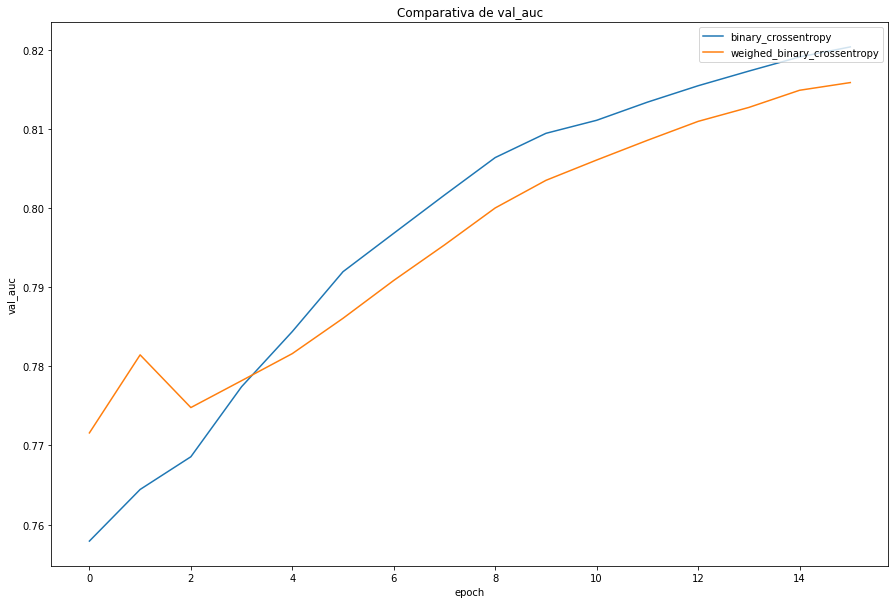

Max. val_auc binary_crossentropy: 0.820396900177002
Max. val_auc weighed_binary_crossentropy:0.8158870935440063


In [20]:
results = {'binary_crossentropy' : res_binary_crossentropy[2], 'weighed_binary_crossentropy' : res_weighed_crossentropy[2]}
plot(results, metric='val_auc')

print('Max. val_auc binary_crossentropy: {}'.format(max(res_binary_crossentropy[2])))
print('Max. val_auc weighed_binary_crossentropy:{}'.format(max(res_weighed_crossentropy[2])))

A partir de la gráfica anterior se puede comprobar que no existe apenas diferencia entre ambas métricas. Se empleará weighed_binary_crossentropy. Si bien para el dataset reducido puede que no tenga mucha diferencia, es posible que sí la tenga cuando se repita el mismo análisis con el dataset completo en el que los datos son mucho más disperos, y la proporción de 0s es muy superior a la de 1s. 

## 5. Arquitecturas pre-entrenadas

En este apartado se definen las funciones de construcción de los modelos que emplea la función **train** definida anteriormente. Se basa en arquitecturas de redes pre-entrenadas disponibles con Keras. Estas redes permiten inicializar los valores a pesos entrenandos sobre ImageNet, por lo que permite beneficiarse del _transfer learning_ y poder congelar un número de capas iniciales ya pre-entrenadas para detectar las características más abstractas.

Se ha optado por realizar las pruebas con InceptionV3, ResNet50, VGG16, InceptionResNetV2 y DenseNet201

In [21]:
def build_InceptionV3(input_shape, params):
    base_model = InceptionV3(
        include_top=False,
        weights="imagenet",
        input_shape=input_shape,
        pooling=params[GLOBAL_POOLING_TYPE],
        #classes=1000
        )
    freeze_all_layers(base_model)
    
    x = base_model.output
    if not params[GLOBAL_POOLING_TYPE]:
        x = Flatten()(x)
    x = Dense(params[DENSE_LAYER_SIZE_PARAM], activation="relu")(x)
    x = Dense(params[OUTPUT_LAYER_SIZE], activation=params[ACTIVATION_FUNCTION])(x)
    model = Model(inputs=base_model.input, outputs=x)
    
    return model

def build_ResNet50(input_shape, params):
    base_model = ResNet50(
        include_top=False,
        weights="imagenet",
        input_shape=input_shape,
        pooling=params[GLOBAL_POOLING_TYPE],
        #classes=1000
        )
    freeze_all_layers(base_model)
    
    x = base_model.output
    if not params[GLOBAL_POOLING_TYPE]:
        x = Flatten()(x)
    x = Dense(params[DENSE_LAYER_SIZE_PARAM], activation="relu")(x)
    x = Dense(params[OUTPUT_LAYER_SIZE], activation=params[ACTIVATION_FUNCTION])(x)
    model = Model(inputs=base_model.input, outputs=x)
    
    return model

def build_VGG16(input_shape, params):
    base_model = VGG16(
        include_top=False,
        weights="imagenet",
        input_shape=input_shape,
        pooling=params[GLOBAL_POOLING_TYPE],
        #classes=1000
        )
    freeze_all_layers(base_model)
    
    x = base_model.output
    if not params[GLOBAL_POOLING_TYPE]:
        x = Flatten()(x)
    x = Dense(params[DENSE_LAYER_SIZE_PARAM], activation="relu")(x)
    x = Dense(params[OUTPUT_LAYER_SIZE], activation=params[ACTIVATION_FUNCTION])(x)
    model = Model(inputs=base_model.input, outputs=x)
    
    return model

def build_InceptionResNetV2(input_shape, params):
    base_model = InceptionResNetV2(
        include_top=False,
        weights="imagenet",
        input_shape=input_shape,
        pooling=params[GLOBAL_POOLING_TYPE],
        #classes=1000
        )
    freeze_all_layers(base_model)
    
    x = base_model.output
    if not params[GLOBAL_POOLING_TYPE]:
        x = Flatten()(x)
    x = Dense(params[DENSE_LAYER_SIZE_PARAM], activation="relu")(x)
    x = Dense(params[OUTPUT_LAYER_SIZE], activation=params[ACTIVATION_FUNCTION])(x)
    model = Model(inputs=base_model.input, outputs=x)
    
    return model

def build_DenseNet201(input_shape, params):
    base_model = DenseNet201(
        include_top=False,
        weights="imagenet",
        input_shape=input_shape,
        pooling=params[GLOBAL_POOLING_TYPE],
        #classes=1000
        )
    freeze_all_layers(base_model)
    
    x = base_model.output
    if not params[GLOBAL_POOLING_TYPE]:
        x = Flatten()(x)
    x = Dense(params[DENSE_LAYER_SIZE_PARAM], activation="relu")(x)
    x = Dense(params[OUTPUT_LAYER_SIZE], activation=params[ACTIVATION_FUNCTION])(x)
    model = Model(inputs=base_model.input, outputs=x)
    
    return model


# 6. Versión 1: Un único clasificador

## 6.1 Entrenamiento

En este apartado se realizará el entrenamiento y evaluación de la versión con un único clasificador para todos los tipos de atributos. 

Cabe destacar que para este tipo de clasificador se empleará la función loss *weighted_binary_crossentropy* tal y como se ha comentado en el apartado 4.3 y la función de activación sigmoide para poder permitir la clasificación multi etiqueta. 

La selección de la mejor versión del modelo para cada una de las arquitecturas probadas se realizará en base a los valores de loss y AUC sobre los datos de validación. 

Lanzamos la búsqueda:

In [22]:
RESET = False
if(RESET):
    %cache -r results_inceptionV3
    %cache -r results_resnet50 
    %cache -r results_vgg16
    %cache -r results_inceptionResNetV2
    %cache -r results_densenet201    

%cache results_inceptionV3 = try_pretrained_model('InceptionV3')
%cache results_resnet50 = try_pretrained_model('ResNet50')
%cache results_vgg16 = try_pretrained_model('VGG16')
%cache results_inceptionResNetV2 = try_pretrained_model('InceptionResNetV2')
%cache results_densenet201 = try_pretrained_model('DenseNet201')

Loading cached value for variable 'results_inceptionV3'. Time since caching: 6 days, 14:32:23.215157
Loading cached value for variable 'results_resnet50'. Time since caching: 6 days, 11:43:55.516655
Loading cached value for variable 'results_vgg16'. Time since caching: 6 days, 8:41:09.110090
Loading cached value for variable 'results_inceptionResNetV2'. Time since caching: 6 days, 2:25:22.102667
Loading cached value for variable 'results_densenet201'. Time since caching: 5 days, 19:05:00.740546


Definimos una función para ordenar los modelos generados en función del valor mínimo de loss sobre el conjunto de validación. El índice de la tabla representa el model_id con el que se ha persistido el modelo, para poder ser recuperado en la fase de evaluación. 

In [23]:
# Ordena todos los modelos en base al máximo accuracy conseguido.  
def sort_by_max_accuracy(df):
    df["min_val_loss"] = df.apply(lambda row: min(row['val_loss']), axis=1)
    df["max_val_auc"] = df.apply(lambda row: max(row['val_auc']), axis=1)
 #   df["max_val_acc"] = df.apply(lambda row: max(row['val_acc']), axis=1)
    df = df.drop(columns=['val_loss', 'val_auc'])
    return df.sort_values(by='min_val_loss', ascending=True).head(n=5)

Mostramos los resultados obtenidos para la arquitectura __InceptionV3__:

In [24]:
results_inceptionV3 = sort_by_max_accuracy(results_inceptionV3)
results_inceptionV3

,global_pooling_type,dense_layer_size,freeze_layers_ratio,val_acc,time,min_val_loss,max_val_auc
24,avg,368,0.80,"[0.8524038195610046, 0.8393028378486633, 0.846...",469.36,0.25,0.89
6,avg,408,0.70,"[0.8123798370361328, 0.8478364944458008, 0.833...",579.84,0.25,0.88
14,avg,152,0.60,"[0.802884578704834, 0.8340144157409668, 0.8331...",499.28,0.25,0.88
17,max,360,0.80,"[0.8150240182876587, 0.8316105604171753, 0.810...",362.60,0.25,0.87
13,avg,168,0.80,"[0.8544471859931946, 0.8236778974533081, 0.844...",353.40,0.26,0.88


Mostramos los resultados obtenidos para la arquitectura __ResNet50__:

In [25]:
results_resnet50 = sort_by_max_accuracy(results_resnet50)
results_resnet50

,global_pooling_type,dense_layer_size,freeze_layers_ratio,val_acc,time,min_val_loss,max_val_auc
11,avg,424,0.50,"[0.8084133863449097, 0.8141826391220093, 0.807...",540.33,0.37,0.84
10,None,168,0.50,"[0.8187500238418579, 0.8216346502304077, 0.824...",553.66,0.38,0.81
22,None,256,0.50,"[0.8228365182876587, 0.8247596621513367, 0.812...",472.41,0.38,0.82
13,None,296,0.80,"[0.8170673251152039, 0.8177884221076965, 0.820...",405.56,0.38,0.80
17,None,312,0.70,"[0.6955528855323792, 0.814302921295166, 0.8210...",454.86,0.38,0.78


Mostramos los resultados obtenidos para la arquitectura __VGG16__:

In [26]:
results_vgg16 = sort_by_max_accuracy(results_vgg16)
results_vgg16

,global_pooling_type,dense_layer_size,freeze_layers_ratio,val_acc,time,min_val_loss,max_val_auc
18,max,496,0.80,"[0.8401442766189575, 0.8512018918991089, 0.850...",429.04,0.22,0.92
22,max,208,0.80,"[0.8235577344894409, 0.8490384221076965, 0.858...",537.08,0.22,0.91
17,None,344,0.80,"[0.8481971025466919, 0.8449519276618958, 0.852...",475.24,0.23,0.91
3,max,256,0.80,"[0.8200721740722656, 0.8485577702522278, 0.858...",532.97,0.24,0.91
9,None,488,0.80,"[0.8465144038200378, 0.8550480604171753, 0.864...",317.44,0.24,0.91


Mostramos los resultados obtenidos para la arquitectura __InceptionResNetV2__:

In [27]:
results_inceptionResNetV2 = sort_by_max_accuracy(results_inceptionResNetV2)
results_inceptionResNetV2

,global_pooling_type,dense_layer_size,freeze_layers_ratio,val_acc,time,min_val_loss,max_val_auc
0,avg,368,0.50,"[0.8129808306694031, 0.778245210647583, 0.7967...","1,134.28",0.28,0.87
12,max,360,0.70,"[0.7731971144676208, 0.7876201868057251, 0.771...","1,426.93",0.28,0.87
17,avg,200,0.60,"[0.792067289352417, 0.7769231200218201, 0.8264...",930.98,0.31,0.87
16,None,216,0.70,"[0.7926682233810425, 0.8195914030075073, 0.801...","1,013.13",0.31,0.84
9,avg,208,0.60,"[0.7379807233810425, 0.7817307710647583, 0.784...",929.84,0.31,0.84


Mostramos los resultados obtenidos para la arquitectura __Densenet201__:

In [28]:
results_densenet201 = sort_by_max_accuracy(results_densenet201)
results_densenet201

,global_pooling_type,dense_layer_size,freeze_layers_ratio,val_acc,time,min_val_loss,max_val_auc
15,avg,416,0.50,"[0.8205528259277344, 0.7536057829856873, 0.811...","1,477.38",0.23,0.88
11,avg,480,0.50,"[0.8187500238418579, 0.8246394991874695, 0.852...","1,026.57",0.24,0.88
18,avg,344,0.60,"[0.7665865421295166, 0.8268029093742371, 0.828...","1,018.73",0.24,0.89
24,avg,344,0.70,"[0.7796875238418579, 0.8469951748847961, 0.870...",761.44,0.24,0.90
3,avg,312,0.60,"[0.7536057233810425, 0.8200721740722656, 0.851...","1,018.79",0.24,0.89


## 6.2 Evaluación

En este apartado se realizará la evaluación de las versiones de cada una de las arquitecturas probadas en el apartado anterior con el que se han obtenido mejores resultados. Se empleará aquellas versiones que minimizan el loss sobre el conjunto de validación. 

Se calculará la metríca de top-k recall (ver [Deep Convolutional Ranking for Multilabel Image Annotation](https://arxiv.org/abs/1312.4894)- apartado 4.2) para establecer la comparativa, tal y como se describe en la memoria del trabajo. Se emplearán valores de k = 3, 5, 6.

En el caso de esta versión del conjunto de datos en el que sabemos a priori que todas las observaciones tienen 6 etiquetas asociadas, nos basaremos en el valor k=6 para decidir con qué modelo se obtienen los mejores resultados. Emplearemos también esta métrica para establecer una comparativa con la versión de un clasificador por tipo de atributo. 

In [29]:
KS =  [3,5,6]

# Calcula
## Número de veces que aparece un atributo en una predicción
## Número de veces en el que la predicción de un atributo se realiza de forma correcta
## Número de veces en el que la predicción de un atributo se realiza de forma incorrecta
def get_prediction_metrics(y_true_df, y_pred, k=6):
    
    # Inicialización de los vectores
    times_predicted = [0] * NUM_CLASSES
    ground_truth = [0] * NUM_CLASSES
    times_correctly_predicted = [0] * NUM_CLASSES
    times_incorrectly_predicted = [0] * NUM_CLASSES

    for index, row in y_true_df.iterrows():
        
        # Obtención de los verdaderos positivos
        true_possitives = np.where(row==1)
        for i in true_possitives[0]:
            ground_truth[i]+=1

        # Obtención de los k valores con mayor probabilidad
        predicted_k_values = np.argpartition(y_pred[index], -k)[-k:]
        for p in predicted_k_values:
            
            # Clasificación
            times_predicted[p]+=1
            if p in true_possitives[0]:
                times_correctly_predicted[p]+=1
            else:
                times_incorrectly_predicted[p]+=1
    return times_predicted, ground_truth, times_correctly_predicted, times_incorrectly_predicted

# Calcula recall, precision y f1 usando macro averaging
def compute_macro_average_metrics(times_predicted, ground_truth, tp, fp):
    m = {}
    recall_per_label = [a/b for a,b in zip(tp,ground_truth)]
    precision_per_label = [a/max(1,b) for a,b in zip(tp,times_predicted)]
    m['recall'] =  sum(recall_per_label)/NUM_CLASSES
    m['precision'] = sum(precision_per_label)/NUM_CLASSES
    f1_per_label = [2 * (p * r) / max(1,(p + r)) for p,r in zip(precision_per_label, recall_per_label)]
    m['f1'] = sum(f1_per_label)/NUM_CLASSES
    return m

# Calcula recall, precision y f1 usando micro averaging
def compute_micro_average_metrics(times_predicted, ground_truth, tp, fp):
    m = {}
    m['recall'] = sum(tp)/sum(ground_truth)
    m['precision'] = sum(tp)/sum(times_predicted)
    m['f1'] = 2 * (m['precision'] * m['recall']) / max(1,(m['precision'] + m['recall']))
    return m

# Calcula recall, precision y f1 usando micro/macro averaging para las k etiquetas con mayor probabilidad
def compute_evaluation_results(y_true_df, y_pred):
    results = {}
    for k in KS:
        # Calculo métricas de clasificación
        times_predicted, ground_truth, tp, fp = get_prediction_metrics(y_true_df, y_pred, k)
        
        results_k = {}
        results[k] = results_k
        # Micro average
        results_k['micro'] = compute_micro_average_metrics(times_predicted, ground_truth, tp, fp)
        
        # Macro average
        results_k['macro'] = compute_macro_average_metrics(times_predicted, ground_truth, tp, fp)
    return results

# Evaluación de un modelo.     
def evaluate(model_name, model_id):
    # Forzar limpieza y pasar el GC
    K.clear_session()
    gc.collect()

    # Recuperar el modelo guardado
    model = load_model(to_model_path(model_name, model_id), compile = False)
    model.compile(optimizer='adam', loss=binary_crossentropy, metrics=[tf.keras.metrics.AUC(name='auc'), 'accuracy'])
    
    # Generator de datos de test
    test_generator = build_test_generator()
    
    # Predicción
    y_pred = model.predict_generator(test_generator, steps=None, max_queue_size=10, workers=1, use_multiprocessing=False, verbose=1) 

    # Carga de las etiquetas del conjunto de test
    partition_attribute_filepath = ANNO_FINE_PATH + "/test_attr.txt"
    y_true_df = pd.read_csv(partition_attribute_filepath, sep = ' ', names = [str(i) for i in range(0,NUM_CLASSES)], index_col=False)
    
    # Calcula resultados en formato r[k][average type][metric] donde
    # k - numero de etiquetas con mayor probabilidad
    # average type - micro|macro
    # metric - precision|recall|f1
    results = compute_evaluation_results(y_true_df, y_pred)
        
    return (y_pred, results)

Recuperamos el ID para cada uno de los modelos con el valor mínimo de loss sobre el conjunto de validación, y lanzamos la evaluación:

In [30]:
RESET = False
if(RESET):
    %cache -r inceptionV3_test_res
    %cache -r resnet50_test_res
    %cache -r vgg16_test_res 
    %cache -r inceptionResNetV2_test_res 
    %cache -r densenet201_test_res 
    
%cache inceptionV3_test_res = evaluate('InceptionV3', model_id = results_inceptionV3.iloc[0].name)
%cache resnet50_test_res = evaluate('ResNet50',model_id = results_resnet50.iloc[0].name)
%cache vgg16_test_res = evaluate('VGG16', model_id = results_vgg16.iloc[0].name)
%cache inceptionResNetV2_test_res = evaluate('InceptionResNetV2', model_id = results_inceptionResNetV2.iloc[0].name)
%cache densenet201_test_res = evaluate('DenseNet201', model_id = results_densenet201.iloc[0].name)

Loading cached value for variable 'inceptionV3_test_res'. Time since caching: 5 days, 19:04:13.278861
Loading cached value for variable 'resnet50_test_res'. Time since caching: 5 days, 19:03:04.284726
Loading cached value for variable 'vgg16_test_res'. Time since caching: 5 days, 19:02:16.776706
Loading cached value for variable 'inceptionResNetV2_test_res'. Time since caching: 5 days, 19:00:43.478184
Loading cached value for variable 'densenet201_test_res'. Time since caching: 5 days, 18:58:29.141969


In [31]:
COLUMNS = ['recall.micro','precision.micro','f1.micro','recall.macro','precision.macro','f1.macro']

def build_result_df(result_list, k):
    rows = []
    names = []
    for model_results, model_name in result_list:
        row = []
        rows.append(row)
        names.append(model_name)
        for avg in ['micro', 'macro']:
            for metric in ['recall', 'precision', 'f1']:
                row.append(model_results[k][avg][metric])

    return pd.DataFrame(rows, columns=COLUMNS, index=names)

In [32]:
result_list = [(inceptionV3_test_res[1], 'InceptionV3'),
               (resnet50_test_res[1], 'ResNet50'),
               (vgg16_test_res[1], 'VGG16'),
               (inceptionResNetV2_test_res[1], 'InceptionResNetV2'),
               (densenet201_test_res[1], 'DenseNet201')]
    
    
build_result_df(result_list, k=3)

,recall.micro,precision.micro,f1.micro,recall.macro,precision.macro,f1.macro
InceptionV3,0.43,0.86,0.57,0.22,0.52,0.27
ResNet50,0.29,0.57,0.33,0.12,0.14,0.08
VGG16,0.44,0.88,0.59,0.23,0.54,0.30
InceptionResNetV2,0.42,0.85,0.56,0.19,0.36,0.22
DenseNet201,0.44,0.88,0.59,0.24,0.51,0.29


In [33]:
build_result_df(result_list, k=5)

,recall.micro,precision.micro,f1.micro,recall.macro,precision.macro,f1.macro
InceptionV3,0.64,0.77,0.70,0.36,0.50,0.38
ResNet50,0.53,0.64,0.58,0.19,0.12,0.15
VGG16,0.67,0.80,0.73,0.38,0.62,0.42
InceptionResNetV2,0.63,0.76,0.69,0.31,0.48,0.31
DenseNet201,0.67,0.80,0.73,0.38,0.53,0.40


In [34]:
build_result_df(result_list, k=6)

,recall.micro,precision.micro,f1.micro,recall.macro,precision.macro,f1.macro
InceptionV3,0.73,0.73,0.73,0.42,0.47,0.41
ResNet50,0.60,0.60,0.60,0.23,0.14,0.17
VGG16,0.76,0.76,0.76,0.45,0.55,0.46
InceptionResNetV2,0.72,0.72,0.72,0.37,0.48,0.35
DenseNet201,0.76,0.76,0.76,0.45,0.52,0.44


# 6.3. Análisis de los resultados

En este apartado se realizará un análisis de los resultados del modelo con el que se han obtenido mejores resultados en el apartado anterior en la métrica de top-6 recall. 

Como se observa en la tabla del apartado anterior, el tipo de arquitectura con el que se obtiene un valor superior es VGG16 por lo que consideraremos éste como el mejor de los modelos probados, y con el que se realizará el análisis. 

En primer lugar vamos a visualizar una muestra de imágenes junto con las etiquetas reales y las etiquetas predichas por el modelo. Para el conjunto de etiquetas predichas, se recupera las 6 etiquetas con mayor probabilidad según el modelo. Se emplea este valor puesto que se sabe a priori que el conjunto de etiquetas real está formado por 6 elementos en esta versión del dataset. Cuando se realice este procedimiento sobre el conjunto de datos completo en el que el número de etiquetas real es variable, se recuperarán aquellas cuyo valor de predicción supere un umbral por definir. 

In [35]:
# Muestra N ejemplos de la partición de test con sus etiquetas reales y las etiquetas predichas
# Para las etiquetas predichas, recupera las k etiquetas con mayor probabilidad. 
def display_examples(y_pred, k=6, n=5):
    for index, row in build_iterator_dataframe('test').iterrows():
        
        # Mostrar imagen
        img = load_img('{}/{}'.format(TEST_PATH, row['filename']))
        plt.title('Ejemplo: {}'.format(index+1))
        plt.imshow(img)
        plt.show()
        
        # Recuperar las etiquetas reales
        true_labels = [column_to_attr_name[i] for i in np.where(row==1)[0]]
        true_labels.sort()
        
        # Recuperar las k etiquetas con mayor probabilidad
        predicted_k_values = np.argpartition(y_pred[index], -k)[-k:]
        predicted_labels = [column_to_attr_name[i] for i in predicted_k_values]
        predicted_labels.sort()
        
        print('True labels: ' + str(true_labels))
        print('Predicted labels: ' + str(predicted_labels))
        
        if(n == index+1):
            return  

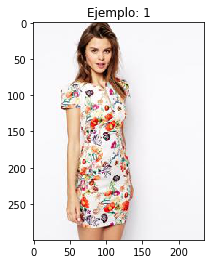

True labels: ['cotton', 'crew_neckline', 'floral', 'mini_length', 'short_sleeve', 'tight']
Predicted labels: ['conventional', 'cotton', 'crew_neckline', 'floral', 'mini_length', 'short_sleeve']


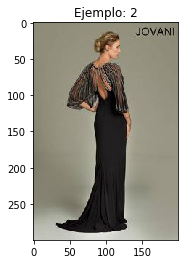

True labels: ['chiffon', 'conventional', 'long_sleeve', 'no_dress', 'no_neckline', 'pleated']
Predicted labels: ['chiffon', 'conventional', 'cotton', 'crew_neckline', 'no_dress', 'solid']


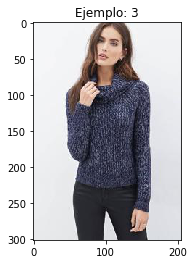

True labels: ['conventional', 'crew_neckline', 'knit', 'long_sleeve', 'no_dress', 'solid']
Predicted labels: ['conventional', 'cotton', 'crew_neckline', 'knit', 'long_sleeve', 'no_dress']


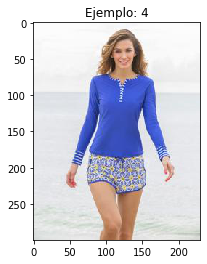

True labels: ['conventional', 'cotton', 'floral', 'no_dress', 'no_neckline', 'sleeveless']
Predicted labels: ['conventional', 'cotton', 'crew_neckline', 'long_sleeve', 'no_dress', 'solid']


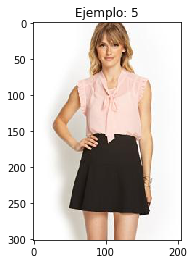

True labels: ['chiffon', 'conventional', 'no_dress', 'sleeveless', 'solid', 'v_neckline']
Predicted labels: ['conventional', 'cotton', 'long_sleeve', 'mini_length', 'solid', 'v_neckline']


In [36]:
# Ejemplos para la red con mejores resultados en los apartados anteriores
y_pred_vgg16 = vgg16_test_res[0]
display_examples(y_pred_vgg16)

In [37]:
# Construcción de la tabla de resultados a partir de la lista de listas de valores predichos por un modelo sobre la partición de test
def build_results_table(y_pred):

    # Carga de las anotaciones reales de la partición de test
    partition_attribute_filepath = ANNO_FINE_PATH + "/test_attr.txt"
    y_true_df = pd.read_csv(partition_attribute_filepath, sep = ' ', names = [str(i) for i in range(0,NUM_CLASSES)], index_col=False)

    # Columna de tipo de atributo
    attr_types = []
    for k, v in attr_type_to_columns.items():
        attr_types.extend([ATTR_TYPES[str(k)]] * len(v))

    # Columna de frecuencia de predicción, Verdaderos positivos y Falsos positivos
    times_predicted, ground_truth, times_correctly_predicted, times_incorrectly_predicted = get_prediction_metrics(y_true_df, y_pred)

    # Columnas de sensibilidad y precisión
    recall = [a/b for a,b in zip(times_correctly_predicted, ground_truth)]
    precision = [a/max(1,b) for a,b in zip(times_correctly_predicted, times_predicted)]
    f1 = [2 * (p * r) / max(1,(p + r)) for p,r in zip(precision, recall)]

    # Creación de dataframe
    d = {'Atributo': attributes, 'Tipo': attr_types, 'Frecuencia real' : ground_truth, 
         'Frecuencia predicción' : times_predicted, 'TP': times_correctly_predicted, 'FP' : times_incorrectly_predicted, 
         'Recall' : recall, 'Precision' : precision, 'F1' : f1}
    return pd.DataFrame(data=d)


def build_results_table_by_attr_type(results):
    df = build_results_table(results).groupby('Tipo').mean()
    return df.drop(columns=['Frecuencia real', 'Frecuencia predicción', 'TP', 'FP'])

Mostramos también los resultados por cada atributo:

In [38]:
build_results_table(y_pred_vgg16)

,Atributo,Tipo,Frecuencia real,Frecuencia predicción,TP,FP,Recall,Precision,F1
0,floral,Estampado,664,700,442,258,0.67,0.63,0.65
1,graphic,Estampado,668,390,255,135,0.38,0.65,0.48
2,striped,Estampado,292,234,186,48,0.64,0.79,0.71
3,embroidered,Estampado,338,27,13,14,0.04,0.48,0.04
4,pleated,Estampado,78,4,1,3,0.01,0.25,0.01
5,solid,Estampado,1898,2185,1652,533,0.87,0.76,0.81
6,lattice,Estampado,62,0,0,0,0.00,0.00,0.00
7,long_sleeve,Tipo de manga,1243,1329,1046,283,0.84,0.79,0.81
8,short_sleeve,Tipo de manga,686,612,443,169,0.65,0.72,0.68
9,sleeveless,Tipo de manga,2071,2102,1827,275,0.88,0.87,0.88


In [39]:
build_results_table_by_attr_type(y_pred_vgg16)

,Recall,Precision,F1
Tipo,,,
Estampado,0.37,0.51,0.38
Forma,0.76,0.78,0.77
Tallaje,0.39,0.54,0.39
Tejido,0.24,0.41,0.23
Tipo de cuello,0.48,0.49,0.48
Tipo de manga,0.79,0.79,0.79


A partir de la tabla anterior se puede observar que la mayor problemática a la hora de entrenar el modelo ha sido el _data imbalace_. Los atributos que aparecen con mayor frecuencia (tanto en las particiones de entrenamiento y validación, como en la de test) suelen predecirse con mayor frecuencia que los atributos minoritarios. Esto implica que atribotos como _leather_ o _faux_ no aparezcan en ninga predicción. Por otro lado llama la atención el bajo número de veces que el modelo predice atributos como _knit_ o _embroidered_. 

En una iteración posterior sobre estos modelos se podría contemplar aumentar el número de ejemplos de los atributos minoritarios en las particiones de entrenamiento y validación, o el empleo de alguna métrica como F1 a la hora de realizar el entrenamiento para solventar este problema. 

Por otro lado, en los casos en los que en una imagen aparecen varias prendas, se ha detectado que las anotaciones pertenecen a una de ellas mientras que el modelo parece predecir las de otra. Esto se puede apreciar en el ejemplo 4, en el que solo hay una diferencia en el conjunto de etiquetas. La etiqueta real es _floral_, que aplica al pantalón corto mientras que el modelo predice _solid_ que aplica a la prenda superior. 

# 7. Versión 2: Un clasificador por tipo de atributo

Como se ha comentado en varias ocasiones, en la versión reducida de este conjunto de datos existe siempre un único atributo de cada tipo asociado a la imagen. Por ello, para la construcción de un clasificador por tipo de atributo se puede emplear la función de loss *categorical_crossentropy* así como la función de activación *softmax* para que cada uno de los clasificadores prediga siempre un único atributo. 

## 7.1 Entrenamiento

El entrenamiento se realiza empleando la misma metodología que con la versión anterior: por cada tipo de atributo se exploran 5 arquitecturas pre-entrenadas, y para cada una de estas arquitecturas se prueban 20 variantes con ciertos parámetros elegidos de forma aleatoria. 

In [40]:
def try_pretrained_models_per_attribute_type():
    res = {}
    for attr_type in range(1,3):
        output_layer_size = len(attr_type_to_columns[str(attr_type)])
        
        res_attr_type = {}
        res[attr_type] = res_attr_type
        for architecture in ['InceptionV3', 'ResNet50', 'VGG16', 'InceptionResNetV2', 'DenseNet201']:
            print('$$$: Starting with attribute type {} and architecture {}'.format(attr_type, architecture))
            res_attr_type[architecture] = try_pretrained_model(architecture, attr_type, 
                                                               'softmax', categorical_crossentropy, output_layer_size)
    return res


In [41]:
# %cache -r results_split_per_attr_type
%cache results_split_per_attr_type = try_pretrained_models_per_attribute_type()

Warning! Expression has changed since last save, which was at 2020-11-15 22:05:50.241235
To store a new value, change the version ('-v' or '--version')  
Loading cached value for variable 'results_split_per_attr_type'. Time since caching: 12 days, 19:06:47.335509


Identificamos los mejores modelos probados por cada tipo de atributo y arquitectura probada:

In [42]:
# Devuelvel la mejor versión del modelo de entre las 20 probadas
def get_best_result(df):
    df["min_val_loss"] = df.apply(lambda row: min(row['val_loss']), axis=1)
    df["max_val_acc"] = df.apply(lambda row: max(row['val_acc']), axis=1)
    df = df.drop(columns=['val_loss', 'val_auc', 'val_acc'])
    best_result = df.sort_values(by='min_val_loss', ascending=True).iloc[0]

    best_result_dict = best_result.to_dict()
    index = best_result.name
    best_result_dict['model_id'] = index
    return best_result_dict

# Devuelve una tabla con las mejores versiones probadas por cada tipo de atributo y arquitectura probada
def get_best_result_per_attribute_type(results):
    best_results_per_attribute_type = {}
    for attr_type in range(1,7):
        
        best_results = pd.DataFrame(columns = ['architecture','model_id', 'global_pooling_type',
                                          'dense_layer_size','freeze_layers_ratio',
                                          'time','min_val_loss', 'max_val_acc'])
        
        for i, architecture in enumerate(['InceptionV3', 'ResNet50', 'VGG16', 'InceptionResNetV2', 'DenseNet201']):
            best_result = get_best_result(results[attr_type][architecture])
            best_results.loc[i] = [architecture, 
                               best_result['model_id'],
                               best_result['global_pooling_type'],
                               best_result['dense_layer_size'],
                               best_result['freeze_layers_ratio'],
                               best_result['time'],
                               best_result['min_val_loss'],
                               best_result['max_val_acc']]
            
            
        best_results_per_attribute_type[attr_type] = best_results
    return best_results_per_attribute_type


In [43]:
r = get_best_result_per_attribute_type(results_split_per_attr_type)

Mejores modelos para el tipo de atributo **Estampado**:

In [44]:
r[1]

,architecture,model_id,global_pooling_type,dense_layer_size,freeze_layers_ratio,time,min_val_loss,max_val_acc
0,InceptionV3,15,avg,184,0.70,453.88,0.44,0.71
1,ResNet50,8,max,200,0.70,273.52,1.11,0.54
2,VGG16,0,max,344,0.80,260.87,0.56,0.73
3,InceptionResNetV2,13,max,432,0.80,833.44,1.00,0.57
4,DenseNet201,11,max,432,0.80,797.16,0.61,0.71


Mejores modelos para el tipo de atributo **Tipo de manga**:

In [45]:
r[2]

,architecture,model_id,global_pooling_type,dense_layer_size,freeze_layers_ratio,time,min_val_loss,max_val_acc
0,InceptionV3,18,avg,416,0.70,577.07,0.18,0.88
1,ResNet50,13,max,272,0.50,536.17,0.86,0.57
2,VGG16,8,avg,200,0.80,515.76,0.27,0.85
3,InceptionResNetV2,6,avg,296,0.50,"1,024.42",0.43,0.83
4,DenseNet201,16,avg,312,0.50,"1,056.32",0.07,0.90


Mejores modelos para el tipo de atributo **Forma**:

In [46]:
r[3]

,architecture,model_id,global_pooling_type,dense_layer_size,freeze_layers_ratio,time,min_val_loss,max_val_acc
0,InceptionV3,16,max,472,0.80,416.48,0.16,0.87
1,ResNet50,1,max,304,0.60,349.99,0.53,0.74
2,VGG16,14,max,240,0.80,358.41,0.17,0.89
3,InceptionResNetV2,10,None,192,0.70,"1,199.24",0.37,0.76
4,DenseNet201,2,None,184,0.80,888.64,0.18,0.84


Mejores modelos para el tipo de atributo **Tipo de cuello**:

In [47]:
r[4]

,architecture,model_id,global_pooling_type,dense_layer_size,freeze_layers_ratio,time,min_val_loss,max_val_acc
0,InceptionV3,9,avg,256,0.70,339.33,0.54,0.70
1,ResNet50,13,avg,336,0.60,534.81,0.90,0.46
2,VGG16,4,None,312,0.80,347.86,0.52,0.68
3,InceptionResNetV2,15,avg,320,0.50,"1,674.90",0.84,0.47
4,DenseNet201,12,avg,304,0.70,857.08,0.45,0.77


Mejores modelos para el tipo de atributo **Tejido**:

In [48]:
r[5]

,architecture,model_id,global_pooling_type,dense_layer_size,freeze_layers_ratio,time,min_val_loss,max_val_acc
0,InceptionV3,2,None,488,0.70,571.42,0.50,0.74
1,ResNet50,0,None,176,0.60,384.22,0.53,0.74
2,VGG16,9,avg,304,0.60,236.89,0.53,0.74
3,InceptionResNetV2,16,avg,464,0.70,486.31,0.56,0.74
4,DenseNet201,0,max,136,0.50,667.64,0.44,0.74


Mejores modelos para el tipo de atributo **Tallaje**:

In [49]:
r[6]

,architecture,model_id,global_pooling_type,dense_layer_size,freeze_layers_ratio,time,min_val_loss,max_val_acc
0,InceptionV3,7,avg,288,0.70,290.85,0.04,0.84
1,ResNet50,19,None,280,0.50,493.76,0.14,0.84
2,VGG16,18,max,368,0.60,313.56,0.18,0.84
3,InceptionResNetV2,18,None,280,0.50,714.78,0.14,0.84
4,DenseNet201,7,max,344,0.80,"1,011.12",0.23,0.88


## 7.2 Evaluación

A continuación seleccionamos la mejor versión para cada uno de los tipos de atributo para realizar una prueba conjunta sobre los datos de test. 

In [50]:
best_models = [[1, 'VGG16', 0],
              [2, 'DenseNet201', 16],
              [3, 'VGG16', 14],
              [4, 'DenseNet201', 12],
              [5, 'DenseNet201', 0],
              [6, 'DenseNet201', 7]]

In [51]:
# Junta los resultados. Convierte, por ejemplo tres listas de tamaño [4000][7] y [4000][3] y [4000][2] en 
# una única lista de tamaño [4000][12], donde el primer índice son elementos de la partición de test y el segundo los atributos
def join_results(r):
    joined = []
    for i,v in enumerate(r.values()):
        for j, o in enumerate(v):
            if(i == 0):
                joined.append(o.tolist())
            else:
                joined[j].extend(o.tolist())
    return joined

# Realiza un cálculo de la partición de test sobre los modelos por tipo de atributo
def evaluate_separate_models(best_models):
    
    # Carga de las etiquetas del conjunto de test
    partition_attribute_filepath = ANNO_FINE_PATH + "/test_attr.txt"
    y_true_df = pd.read_csv(partition_attribute_filepath, sep = ' ', names = [str(i) for i in range(0,NUM_CLASSES)], index_col=False)
    
    y_pred = {}
    
    for params in best_models:
    
        attr_type = params[0]
        model_name = params[1]
        model_id = params[2]
    
        # Forzar limpieza y pasar el GC
        K.clear_session()
        gc.collect()

        # Recuperar el modelo guardado
        model = load_model(to_model_path(model_name, model_id, attr_type), compile = False)
        model.compile(optimizer='adam', loss=categorical_crossentropy, metrics=[tf.keras.metrics.AUC(name='auc'), 'accuracy'])

        # Generator de datos de test
        test_generator = build_test_generator(attr_type = attr_type)

        # Predicción
        y_pred[attr_type] = model.predict_generator(test_generator, steps=None, max_queue_size=10, workers=1, use_multiprocessing=False, verbose=1) 
    
    # Fusiona los resultados en una única lista
    y_pred_joined = join_results(y_pred)
    
    # Calcula resultados en formato r[k][average type][metric] donde
    # k - numero de etiquetas con mayor probabilidad
    # average type - micro|macro
    # metric - precision|recall|f1
    results = compute_evaluation_results(y_true_df, y_pred_joined)
    
    return (y_pred_joined, results)
 
    

In [52]:
#%cache -r res_split_models
%cache res_split_models = evaluate_separate_models(best_models)

Loading cached value for variable 'res_split_models'. Time since caching: 8 days, 18:00:45.668634


In [53]:
result_list = [(inceptionV3_test_res[1], 'InceptionV3'),
               (resnet50_test_res[1], 'ResNet50'),
               (vgg16_test_res[1], 'VGG16'),
               (inceptionResNetV2_test_res[1], 'InceptionResNetV2'),
               (densenet201_test_res[1], 'DenseNet201'),
               (res_split_models[1], 'Split model')] 

In [54]:
build_result_df(result_list, k=3)

,recall.micro,precision.micro,f1.micro,recall.macro,precision.macro,f1.macro
InceptionV3,0.43,0.86,0.57,0.22,0.52,0.27
ResNet50,0.29,0.57,0.33,0.12,0.14,0.08
VGG16,0.44,0.88,0.59,0.23,0.54,0.30
InceptionResNetV2,0.42,0.85,0.56,0.19,0.36,0.22
DenseNet201,0.44,0.88,0.59,0.24,0.51,0.29
Split model,0.42,0.85,0.57,0.20,0.56,0.26


In [55]:
build_result_df(result_list, k=5)

,recall.micro,precision.micro,f1.micro,recall.macro,precision.macro,f1.macro
InceptionV3,0.64,0.77,0.70,0.36,0.50,0.38
ResNet50,0.53,0.64,0.58,0.19,0.12,0.15
VGG16,0.67,0.80,0.73,0.38,0.62,0.42
InceptionResNetV2,0.63,0.76,0.69,0.31,0.48,0.31
DenseNet201,0.67,0.80,0.73,0.38,0.53,0.40
Split model,0.67,0.81,0.73,0.37,0.50,0.40


In [56]:
build_result_df(result_list, k=6)

,recall.micro,precision.micro,f1.micro,recall.macro,precision.macro,f1.macro
InceptionV3,0.73,0.73,0.73,0.42,0.47,0.41
ResNet50,0.60,0.60,0.60,0.23,0.14,0.17
VGG16,0.76,0.76,0.76,0.45,0.55,0.46
InceptionResNetV2,0.72,0.72,0.72,0.37,0.48,0.35
DenseNet201,0.76,0.76,0.76,0.45,0.52,0.44
Split model,0.77,0.77,0.77,0.45,0.51,0.45


## 7.3 Análisis de los resultados

Al igual que con la versión anterior, vamos a mostrar una muestra de la partición de test junto con las etiquetas reales y las etiquetas predichas.

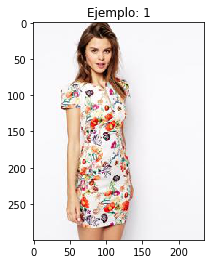

True labels: ['cotton', 'crew_neckline', 'floral', 'mini_length', 'short_sleeve', 'tight']
Predicted labels: ['conventional', 'cotton', 'crew_neckline', 'floral', 'mini_length', 'short_sleeve']


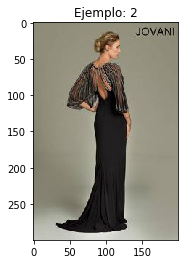

True labels: ['chiffon', 'conventional', 'long_sleeve', 'no_dress', 'no_neckline', 'pleated']
Predicted labels: ['conventional', 'cotton', 'crew_neckline', 'maxi_length', 'short_sleeve', 'solid']


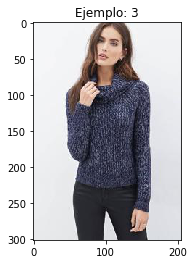

True labels: ['conventional', 'crew_neckline', 'knit', 'long_sleeve', 'no_dress', 'solid']
Predicted labels: ['conventional', 'cotton', 'crew_neckline', 'long_sleeve', 'no_dress', 'solid']


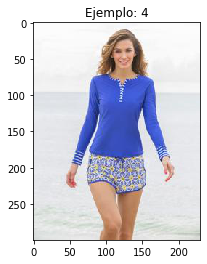

True labels: ['conventional', 'cotton', 'floral', 'no_dress', 'no_neckline', 'sleeveless']
Predicted labels: ['conventional', 'cotton', 'crew_neckline', 'long_sleeve', 'no_dress', 'solid']


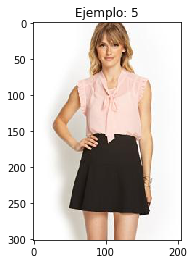

True labels: ['chiffon', 'conventional', 'no_dress', 'sleeveless', 'solid', 'v_neckline']
Predicted labels: ['conventional', 'cotton', 'mini_length', 'no_neckline', 'sleeveless', 'solid']


In [57]:
y_pred_combined = res_split_models[0]
display_examples(y_pred_combined)

Mostramos también los resultados por cada atributo:

In [58]:
build_results_table(y_pred_combined)

,Atributo,Tipo,Frecuencia real,Frecuencia predicción,TP,FP,Recall,Precision,F1
0,floral,Estampado,664,664,421,243,0.63,0.63,0.63
1,graphic,Estampado,668,503,310,193,0.46,0.62,0.53
2,striped,Estampado,292,200,165,35,0.57,0.82,0.67
3,embroidered,Estampado,338,0,0,0,0.00,0.00,0.00
4,pleated,Estampado,78,0,0,0,0.00,0.00,0.00
5,solid,Estampado,1898,2516,1750,766,0.92,0.70,0.79
6,lattice,Estampado,62,1,1,0,0.02,1.00,0.03
7,long_sleeve,Tipo de manga,1243,1178,1044,134,0.84,0.89,0.86
8,short_sleeve,Tipo de manga,686,631,514,117,0.75,0.81,0.78
9,sleeveless,Tipo de manga,2071,2213,1927,286,0.93,0.87,0.90


In [59]:
build_results_table_by_attr_type(y_pred_combined)

,Recall,Precision,F1
Tipo,,,
Estampado,0.37,0.54,0.38
Forma,0.71,0.79,0.74
Tallaje,0.47,0.54,0.48
Tejido,0.17,0.14,0.14
Tipo de cuello,0.51,0.50,0.50
Tipo de manga,0.84,0.86,0.85


A partir de la muestra de 5 imágenes con los atributos reales y predichos, se puede comprobar que esta versión aparentemente predice una mayor cantidad de etiquetas incorrectas en comparación a la primera versión. Sin embargo, se ha obtenido un valor superior en más de dos puntos para la métrica de top-6 recall. 

En la tabla de desglose se observa que esta versión tiende a predecir en mayor medida los atributos mayoritarios y, probablemente, gracias a esto obtenga un valor superior en la métrica. Por ello es neceario evaluar si se puede emplear otro tipo de métrica (F1?) para realizar la comparación más adecuada.  

## 8. Conclusiones

Se ha obtenido un resultado superior para la versión de un clasificador por tipo de atributo (top-6 recall = 0.77) que para la versión de un único clasificador (top-6 recall = 0.74). Sin embargo, este resultado evidencia que para establecer la comparación probablemente sea neceario emplear otro tipo de métrica puesto que analizando el desglose de resultados y una muestra de atributos reales y predichos, se ha comprobado que esta segunda versión tiende a predecir en mayor medida los atributos mayoritarios en el set de datos. En los resultados de la primera versión existen 7 atributos que nunca han sido predichos, y 2 más con menos de 100 predicciones. Con esta segunda versión, estos números se incrementan a 8 y 3, respectivamente. 

Tal y como se ha ilustrado en el notebook de análisis de datos, este problema se produce por el _data imbalance_ puesto que dentro de un mismo tipo de atributo existen atributos con mucha más frecuencia de aparición que otros, por lo que es difícil que el modelo llegue a aprender las características de los atributos minoritarios. 

Hay que tener en cuenta también que en la versión de un modelo por tipo de atributo se ha incorporado cierto conocimiento a priori a partir de la investigación del conjunto de datos, y es que siempre existe un único atributo por cada tipo, lo que ha permitido emplear clasificadores basados en categorical crossentropy y softmax. En el caso de haber empleado exáctamente los mismos parámetros en ambas versiones (weighted binary crossentropy y sigmoid), los resultados podrían haber sido distintos. 

Por otro lado, al no haber incluido en los ningún tipo de landmarks ni bounding boxes, en las imágenes en las que aparecen varias prendas, es posible que las anotaciones se refieran a unas de ellas mientras que las etiquetas predichas por los modelos apliquen a otra, influyendo de forma negativa en los resultados de ambas versiones. 

# 10. Correción de Data Imbalance

En los resultados de los dos tipos de modelo se aprecia  

## 10.1 Class weight

Se asignarán pesos de forma inversamente proporcional al número de apariciones de una etiqueta dentro de la partición de entrenamiento. Supongamos, por ejemplo, una muestra de 20 observaciones donde la etiqueta A tiene valor positivo en 10 de ellas y la etiqueta B en 2 de ellas. Los pesos calculados serían:
* A: 20/10 = 2
* B: 20/2 = 10

In [60]:
# Calcula los pesos en base a la inversa de la proporción de la etiqueta con respecto al número de muestras del dataset
#Ejemplo: para una etiqueta con 20 ocurrencias en 4000 observaciones, el peso sería 200 (4000/20)
def compute_class_weights():
    partition_attribute_filepath = ANNO_FINE_PATH + "/test_attr.txt"
    y_true_df = pd.read_csv(partition_attribute_filepath, sep = ' ', names = [str(i) for i in range(0,NUM_CLASSES)], index_col=False)
    attr_frequencies = y_true_df.sum().tolist()
    test_size = len(y_true_df)
    weights = [test_size/f for f in attr_frequencies]
    return weights

In [61]:
MODEL_ID = 'data_imbalance'

# Entrena un modelo nuevo a partir de los resultados de la versión base de un modelo dado
def recompute(results,
              model_name,
              model_id,
              class_weight = None,
              output_layer_size = NUM_CLASSES, 
              activation_function = 'sigmoid', 
              loss_function = binary_crossentropy,
              attr_type = None):
    params = {}
    params[GLOBAL_POOLING_TYPE] = results['global_pooling_type']
    params[DENSE_LAYER_SIZE_PARAM] = results['dense_layer_size']
    freeze_layers_ratio = results['freeze_layers_ratio']
            
    # Definición de la función de activación para usar en la capa de salida
    params[ACTIVATION_FUNCTION] = activation_function
    params[OUTPUT_LAYER_SIZE] = output_layer_size
    
            
    # Llamada a la función de entrenamiento definida en apartados anteriores
    (val_loss,  val_acc, val_auc) = train(model_name, model_id, store_model=True, two_step_fit=True, 
                                          freeze_layers_ratio=freeze_layers_ratio, model_build_params=params, attr_type=attr_type, 
                                          loss_function=loss_function, class_weight=class_weight)
    
    return  (val_loss,  val_acc, val_auc)


# Entrena y evalua un modelo nuevo a partir de los resultados de la versión base de un modelo dado
def reevaluate(model_name,
               model_id,
               results_without_class_weights, 
               class_weight=None,
               attr_type=None):
    results = results_without_class_weights.iloc[0]
    results_with_class_weights = recompute(results, model_name, model_id, class_weight)
    return evaluate(model_name, model_id = model_id)


# Calcula los pesos de cada etiqueta y entrena y evalua un modelo nuevo
def reevaluate_with_class_weights(model_name,
                                  results_without_class_weights, 
                                  attr_type=None):
    class_weight = compute_class_weights()
    return reevaluate(model_name, 'class_weight', results_without_class_weights, class_weight, None)


In [62]:
%cache vgg16_test_res_with_cw = reevaluate_with_class_weights('VGG16', results_vgg16)

Loading cached value for variable 'vgg16_test_res_with_cw'. Time since caching: 4 days, 18:37:17.608915


In [63]:
result_list = [(vgg16_test_res[1], 'VGG16 base'),
               (vgg16_test_res_with_cw[1], 'VGG16 w. class weight')]
build_result_df(result_list, k=6)

,recall.micro,precision.micro,f1.micro,recall.macro,precision.macro,f1.macro
VGG16 base,0.76,0.76,0.76,0.45,0.55,0.46
VGG16 w. class weight,0.73,0.73,0.73,0.41,0.49,0.41


In [64]:
build_results_table(vgg16_test_res[0])

,Atributo,Tipo,Frecuencia real,Frecuencia predicción,TP,FP,Recall,Precision,F1
0,floral,Estampado,664,700,442,258,0.67,0.63,0.65
1,graphic,Estampado,668,390,255,135,0.38,0.65,0.48
2,striped,Estampado,292,234,186,48,0.64,0.79,0.71
3,embroidered,Estampado,338,27,13,14,0.04,0.48,0.04
4,pleated,Estampado,78,4,1,3,0.01,0.25,0.01
5,solid,Estampado,1898,2185,1652,533,0.87,0.76,0.81
6,lattice,Estampado,62,0,0,0,0.00,0.00,0.00
7,long_sleeve,Tipo de manga,1243,1329,1046,283,0.84,0.79,0.81
8,short_sleeve,Tipo de manga,686,612,443,169,0.65,0.72,0.68
9,sleeveless,Tipo de manga,2071,2102,1827,275,0.88,0.87,0.88


In [65]:
build_results_table(vgg16_test_res_with_cw[0])

,Atributo,Tipo,Frecuencia real,Frecuencia predicción,TP,FP,Recall,Precision,F1
0,floral,Estampado,664,584,385,199,0.58,0.66,0.62
1,graphic,Estampado,668,442,270,172,0.40,0.61,0.49
2,striped,Estampado,292,172,144,28,0.49,0.84,0.62
3,embroidered,Estampado,338,2,0,2,0.00,0.00,0.00
4,pleated,Estampado,78,0,0,0,0.00,0.00,0.00
5,solid,Estampado,1898,2437,1738,699,0.92,0.71,0.80
6,lattice,Estampado,62,0,0,0,0.00,0.00,0.00
7,long_sleeve,Tipo de manga,1243,1323,986,337,0.79,0.75,0.77
8,short_sleeve,Tipo de manga,686,306,229,77,0.33,0.75,0.46
9,sleeveless,Tipo de manga,2071,2373,1876,497,0.91,0.79,0.84


In [66]:
build_results_table_by_attr_type(vgg16_test_res[0])

,Recall,Precision,F1
Tipo,,,
Estampado,0.37,0.51,0.38
Forma,0.76,0.78,0.77
Tallaje,0.39,0.54,0.39
Tejido,0.24,0.41,0.23
Tipo de cuello,0.48,0.49,0.48
Tipo de manga,0.79,0.79,0.79


## 11.2 Oversampling y undersampling por etiqueta

In [67]:
MODEL_ID_OVERSAMPLING = "oversampling"

def reevaluate_with_oversampling(model_name,
                                  results_without_class_weights, 
                                  attr_type=None):
    model_id = MODEL_ID_OVERSAMPLING
    return reevaluate(model_name, model_id, results_without_class_weights, None, None)

def build_iterator_dataframe(partition, attr_type=None):
    if partition == 'train':
        partition_attribute_filepath = ANNO_FINE_PATH + "/" + partition + "_attr_v2.txt"
        data = pd.read_csv(partition_attribute_filepath, sep = ' ', index_col=False, header=0)
    else:
        partition_attribute_filepath = ANNO_FINE_PATH + "/" + partition + "_attr.txt"
        data = pd.read_csv(partition_attribute_filepath, sep = ' ', names = attributes, index_col=False)
    
        if 'filename' not in data.columns:
            data['filename'] = [str(i) + '.jpg' for i in range(0,len(data))]
    return data

In [68]:
TRAIN_FILENAME = "train_attr_v2.txt"

#%cache -r vgg16_test_res_with_xx
%cache vgg16_test_res_with_xx = reevaluate('VGG16', 'data_imbalance', results_vgg16)
result_list = [(vgg16_test_res[1], 'VGG16 base'),
               (vgg16_test_res_with_xx[1], 'VGG16 w. sampling')]
build_result_df(result_list, k=6)

Warning! Expression has changed since last save, which was at 2020-11-23 23:59:24.557395
To store a new value, change the version ('-v' or '--version')  
Loading cached value for variable 'vgg16_test_res_with_xx'. Time since caching: 4 days, 17:13:19.742348


,recall.micro,precision.micro,f1.micro,recall.macro,precision.macro,f1.macro
VGG16 base,0.76,0.76,0.76,0.45,0.55,0.46
VGG16 w. sampling,0.65,0.65,0.65,0.47,0.50,0.42


In [69]:
build_results_table(vgg16_test_res_with_xx[0])

,Atributo,Tipo,Frecuencia real,Frecuencia predicción,TP,FP,Recall,Precision,F1
0,floral,Estampado,664,318,234,84,0.35,0.74,0.48
1,graphic,Estampado,668,498,273,225,0.41,0.55,0.45
2,striped,Estampado,292,371,213,158,0.73,0.57,0.64
3,embroidered,Estampado,338,305,80,225,0.24,0.26,0.12
4,pleated,Estampado,78,129,38,91,0.49,0.29,0.29
5,solid,Estampado,1898,1285,1063,222,0.56,0.83,0.67
6,lattice,Estampado,62,70,30,40,0.48,0.43,0.41
7,long_sleeve,Tipo de manga,1243,1681,1069,612,0.86,0.64,0.73
8,short_sleeve,Tipo de manga,686,1354,486,868,0.71,0.36,0.48
9,sleeveless,Tipo de manga,2071,1149,981,168,0.47,0.85,0.61


In [70]:
MODEL_ID_ONE_SHOT = "os"

def reevaluate_with_one_shot(model_name,
                                  results_without_class_weights, 
                                  attr_type=None):
    model_id = MODEL_ID_ONE_SHOT
    return 

def build_iterator_dataframe(partition, attr_type=None):
    if partition == 'train':
        partition_attribute_filepath = ANNO_FINE_PATH + "/" + partition + "_attr_v3.txt"
        data = pd.read_csv(partition_attribute_filepath, sep = ' ', index_col=False, header=0)
    else:
        partition_attribute_filepath = ANNO_FINE_PATH + "/" + partition + "_attr.txt"
        data = pd.read_csv(partition_attribute_filepath, sep = ' ', names = attributes, index_col=False)
    
        if 'filename' not in data.columns:
            data['filename'] = [str(i) + '.jpg' for i in range(0,len(data))]
    return data

## 11.3 Una observación por combinación de etiquetas

In [71]:
def build_iterator_dataframe(partition, attr_type=None):
    if partition == 'train':
        partition_attribute_filepath = ANNO_FINE_PATH + "/" + TRAIN_FILENAME
        data = pd.read_csv(partition_attribute_filepath, sep = ' ', index_col=False, header=0)
    else:
        partition_attribute_filepath = ANNO_FINE_PATH + "/" + partition + "_attr.txt"
        data = pd.read_csv(partition_attribute_filepath, sep = ' ', names = attributes, index_col=False)
    
        if 'filename' not in data.columns:
            data['filename'] = [str(i) + '.jpg' for i in range(0,len(data))]
    return data

In [72]:
TRAIN_FILENAME = "train_attr_v3.txt"
%cache vgg16_test_res_with_os = reevaluate('VGG16', 'data_imbalance_n1', results_vgg16)
result_list = [(vgg16_test_res[1], 'VGG16 base'),
               (vgg16_test_res_with_os[1], 'VGG16 w. single sample')]
build_result_df(result_list, k=6)

Warning! Expression has changed since last save, which was at 2020-11-23 23:21:33.111193
To store a new value, change the version ('-v' or '--version')  
Loading cached value for variable 'vgg16_test_res_with_os'. Time since caching: 4 days, 17:51:12.390391


,recall.micro,precision.micro,f1.micro,recall.macro,precision.macro,f1.macro
VGG16 base,0.76,0.76,0.76,0.45,0.55,0.46
VGG16 w. single sample,0.65,0.65,0.65,0.50,0.49,0.44


In [73]:
build_results_table(vgg16_test_res_with_os[0])

,Atributo,Tipo,Frecuencia real,Frecuencia predicción,TP,FP,Recall,Precision,F1
0,floral,Estampado,664,550,327,223,0.49,0.59,0.54
1,graphic,Estampado,668,288,158,130,0.24,0.55,0.26
2,striped,Estampado,292,349,209,140,0.72,0.60,0.65
3,embroidered,Estampado,338,247,88,159,0.26,0.36,0.19
4,pleated,Estampado,78,96,34,62,0.44,0.35,0.31
5,solid,Estampado,1898,1640,1302,338,0.69,0.79,0.74
6,lattice,Estampado,62,52,24,28,0.39,0.46,0.36
7,long_sleeve,Tipo de manga,1243,1421,1028,393,0.83,0.72,0.77
8,short_sleeve,Tipo de manga,686,827,423,404,0.62,0.51,0.56
9,sleeveless,Tipo de manga,2071,1758,1498,260,0.72,0.85,0.78


## 11.4 N observaciones por combinaciones de etiquetas sin upsampling

In [74]:
RESET = True
if RESET:
    %cache -r vgg16_test_res_n3
    %cache -r vgg16_test_res_n5
    %cache -r vgg16_test_res_n10
    %cache -r vgg16_test_res_n15      

TRAIN_FILENAME = "train_attr_n3.txt"
%cache vgg16_test_res_n3 = reevaluate('VGG16', 'data_imbalance_n3', results_vgg16)
TRAIN_FILENAME = "train_attr_n5.txt"
%cache vgg16_test_res_n5 = reevaluate('VGG16', 'data_imbalance_n5', results_vgg16)
TRAIN_FILENAME = "train_attr_n10_us.txt"
%cache vgg16_test_res_n10 = reevaluate('VGG16', 'data_imbalance_n10', results_vgg16)
TRAIN_FILENAME = "train_attr_n15_us.txt"
%cache vgg16_test_res_n15 = reevaluate('VGG16', 'data_imbalance_n15', results_vgg16)

Resetting cached values for vgg16_test_res_n3
Resetting cached values for vgg16_test_res_n5
Resetting cached values for vgg16_test_res_n10
Resetting cached values for vgg16_test_res_n15
Creating new value for variable 'vgg16_test_res_n3'
Found 2026 validated image filenames.
./data/anno_fine/train
Found 2000 validated image filenames.
Epoch 1/100
50/50 [==============================] - 13s 259ms/step - loss: 0.5317 - auc: 0.6732 - accuracy: 0.7502 - val_loss: 0.4720 - val_auc: 0.7255 - val_accuracy: 0.7570
Epoch 2/100
50/50 [==============================] - 7s 146ms/step - loss: 0.4824 - auc: 0.7377 - accuracy: 0.7675 - val_loss: 0.4245 - val_auc: 0.7492 - val_accuracy: 0.7965
Epoch 3/100
50/50 [==============================] - 7s 143ms/step - loss: 0.4902 - auc: 0.7544 - accuracy: 0.7656 - val_loss: 0.3899 - val_auc: 0.7632 - val_accuracy: 0.8275
Epoch 4/100
50/50 [==============================] - 7s 144ms/step - loss: 0.4702 - auc: 0.7700 - accuracy: 0.7802 - val_loss: 0.3880 - v

50/50 [==============================] - 8s 151ms/step - loss: 0.3752 - auc: 0.8357 - accuracy: 0.8235 - val_loss: 0.3301 - val_auc: 0.8377 - val_accuracy: 0.8465

Epoch 00013: val_auc improved from 0.83367 to 0.83774, saving model to ./model/VGG16_data_imbalance_n3.h5
Epoch 14/100
50/50 [==============================] - 8s 154ms/step - loss: 0.3708 - auc: 0.8395 - accuracy: 0.8238 - val_loss: 0.3224 - val_auc: 0.8415 - val_accuracy: 0.8581

Epoch 00014: val_auc improved from 0.83774 to 0.84147, saving model to ./model/VGG16_data_imbalance_n3.h5
Epoch 15/100
50/50 [==============================] - 8s 154ms/step - loss: 0.3630 - auc: 0.8433 - accuracy: 0.8277 - val_loss: 0.3185 - val_auc: 0.8449 - val_accuracy: 0.8522

Epoch 00015: val_auc improved from 0.84147 to 0.84486, saving model to ./model/VGG16_data_imbalance_n3.h5
Epoch 16/100
50/50 [==============================] - 8s 154ms/step - loss: 0.3665 - auc: 0.8461 - accuracy: 0.8313 - val_loss: 0.3184 - val_auc: 0.8475 - val_accur

Epoch 11/100
50/50 [==============================] - 7s 145ms/step - loss: 0.4204 - auc: 0.8067 - accuracy: 0.7977 - val_loss: 0.3480 - val_auc: 0.8090 - val_accuracy: 0.8415
Epoch 12/100
50/50 [==============================] - 7s 146ms/step - loss: 0.4249 - auc: 0.8110 - accuracy: 0.7963 - val_loss: 0.3951 - val_auc: 0.8129 - val_accuracy: 0.8311
Epoch 13/100
50/50 [==============================] - 7s 141ms/step - loss: 0.4231 - auc: 0.8141 - accuracy: 0.7971 - val_loss: 0.3712 - val_auc: 0.8156 - val_accuracy: 0.8303
Epoch 14/100
50/50 [==============================] - 7s 145ms/step - loss: 0.4209 - auc: 0.8169 - accuracy: 0.8033 - val_loss: 0.3611 - val_auc: 0.8184 - val_accuracy: 0.8310
Epoch 15/100
50/50 [==============================] - 7s 149ms/step - loss: 0.4172 - auc: 0.8195 - accuracy: 0.8013 - val_loss: 0.3641 - val_auc: 0.8208 - val_accuracy: 0.8335

Epoch 00015: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Epoch 16/100
50/50 [==================


Epoch 00023: val_auc improved from 0.86259 to 0.86391, saving model to ./model/VGG16_data_imbalance_n5.h5
Epoch 24/100
50/50 [==============================] - 8s 155ms/step - loss: 0.3614 - auc: 0.8647 - accuracy: 0.8369 - val_loss: 0.2977 - val_auc: 0.8654 - val_accuracy: 0.8695

Epoch 00024: val_auc improved from 0.86391 to 0.86540, saving model to ./model/VGG16_data_imbalance_n5.h5
Epoch 25/100
50/50 [==============================] - 8s 154ms/step - loss: 0.3536 - auc: 0.8661 - accuracy: 0.8379 - val_loss: 0.3084 - val_auc: 0.8670 - val_accuracy: 0.8671

Epoch 00025: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00025: val_auc improved from 0.86540 to 0.86702, saving model to ./model/VGG16_data_imbalance_n5.h5
Epoch 26/100
50/50 [==============================] - 8s 151ms/step - loss: 0.3445 - auc: 0.8677 - accuracy: 0.8440 - val_loss: 0.3080 - val_auc: 0.8686 - val_accuracy: 0.8745

Epoch 00026: val_auc improved from 0.86702 to 0.86863, saving model 

Epoch 1/100
50/50 [==============================] - 9s 178ms/step - loss: 0.4805 - auc: 0.7268 - accuracy: 0.7788 - val_loss: 0.3880 - val_auc: 0.7894 - val_accuracy: 0.8180

Epoch 00001: val_auc improved from -inf to 0.78938, saving model to ./model/VGG16_data_imbalance_n10.h5
Epoch 2/100
50/50 [==============================] - 8s 155ms/step - loss: 0.4487 - auc: 0.8019 - accuracy: 0.7917 - val_loss: 0.4401 - val_auc: 0.7989 - val_accuracy: 0.7853

Epoch 00002: val_auc improved from 0.78938 to 0.79894, saving model to ./model/VGG16_data_imbalance_n10.h5
Epoch 3/100
50/50 [==============================] - 8s 157ms/step - loss: 0.4406 - auc: 0.7983 - accuracy: 0.7877 - val_loss: 0.4100 - val_auc: 0.8022 - val_accuracy: 0.8055

Epoch 00003: val_auc improved from 0.79894 to 0.80216, saving model to ./model/VGG16_data_imbalance_n10.h5
Epoch 4/100
50/50 [==============================] - 8s 154ms/step - loss: 0.4328 - auc: 0.8048 - accuracy: 0.7894 - val_loss: 0.3811 - val_auc: 0.8086 - 

50/50 [==============================] - 8s 158ms/step - loss: 0.3074 - auc: 0.8761 - accuracy: 0.8690 - val_loss: 0.3018 - val_auc: 0.8763 - val_accuracy: 0.8488

Epoch 00029: val_auc improved from 0.87559 to 0.87635, saving model to ./model/VGG16_data_imbalance_n10.h5
Epoch 30/100
50/50 [==============================] - 8s 154ms/step - loss: 0.2975 - auc: 0.8768 - accuracy: 0.8719 - val_loss: 0.3103 - val_auc: 0.8772 - val_accuracy: 0.8541

Epoch 00030: val_auc improved from 0.87635 to 0.87725, saving model to ./model/VGG16_data_imbalance_n10.h5
Epoch 31/100
50/50 [==============================] - 8s 156ms/step - loss: 0.2953 - auc: 0.8777 - accuracy: 0.8717 - val_loss: 0.3210 - val_auc: 0.8781 - val_accuracy: 0.8483

Epoch 00031: val_auc improved from 0.87725 to 0.87806, saving model to ./model/VGG16_data_imbalance_n10.h5
Epoch 32/100
50/50 [==============================] - 8s 151ms/step - loss: 0.2877 - auc: 0.8785 - accuracy: 0.8710 - val_loss: 0.3316 - val_auc: 0.8789 - val_ac

50/50 [==============================] - 8s 154ms/step - loss: 0.4145 - auc: 0.7998 - accuracy: 0.8037 - val_loss: 0.3847 - val_auc: 0.8036 - val_accuracy: 0.7966

Epoch 00004: val_auc improved from 0.79441 to 0.80357, saving model to ./model/VGG16_data_imbalance_n15.h5
Epoch 5/100
50/50 [==============================] - 8s 154ms/step - loss: 0.4274 - auc: 0.8056 - accuracy: 0.7973 - val_loss: 0.3782 - val_auc: 0.8092 - val_accuracy: 0.8272

Epoch 00005: val_auc improved from 0.80357 to 0.80925, saving model to ./model/VGG16_data_imbalance_n15.h5
Epoch 6/100
50/50 [==============================] - 8s 154ms/step - loss: 0.4158 - auc: 0.8126 - accuracy: 0.8006 - val_loss: 0.4009 - val_auc: 0.8141 - val_accuracy: 0.8097

Epoch 00006: val_auc improved from 0.80925 to 0.81407, saving model to ./model/VGG16_data_imbalance_n15.h5
Epoch 7/100
50/50 [==============================] - 8s 150ms/step - loss: 0.3996 - auc: 0.8162 - accuracy: 0.8127 - val_loss: 0.3586 - val_auc: 0.8186 - val_accur

50/50 [==============================] - 8s 151ms/step - loss: 0.2849 - auc: 0.8775 - accuracy: 0.8775 - val_loss: 0.3230 - val_auc: 0.8778 - val_accuracy: 0.8453

Epoch 00032: val_auc improved from 0.87719 to 0.87784, saving model to ./model/VGG16_data_imbalance_n15.h5
Epoch 33/100
50/50 [==============================] - 8s 155ms/step - loss: 0.2842 - auc: 0.8782 - accuracy: 0.8771 - val_loss: 0.3507 - val_auc: 0.8786 - val_accuracy: 0.8470

Epoch 00033: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 00033: val_auc improved from 0.87784 to 0.87863, saving model to ./model/VGG16_data_imbalance_n15.h5
Epoch 34/100
50/50 [==============================] - 8s 154ms/step - loss: 0.2900 - auc: 0.8790 - accuracy: 0.8727 - val_loss: 0.2915 - val_auc: 0.8792 - val_accuracy: 0.8520

Epoch 00034: val_auc improved from 0.87863 to 0.87924, saving model to ./model/VGG16_data_imbalance_n15.h5
Epoch 35/100
50/50 [==============================] - 8s 154ms/step - loss: 0.2

In [75]:
result_list = [(vgg16_test_res[1], 'VGG16'),
               (vgg16_test_res_n3[1], 'VGG16 n3'),
               (vgg16_test_res_n5[1], 'VGG16 n5'),
               (vgg16_test_res_n10[1], 'VGG16 n10'),     
               (vgg16_test_res_n15[1], 'VGG16 n15'),                 
              ]
build_result_df(result_list, k=6)

,recall.micro,precision.micro,f1.micro,recall.macro,precision.macro,f1.macro
VGG16,0.76,0.76,0.76,0.45,0.55,0.46
VGG16 n3,0.70,0.70,0.70,0.49,0.53,0.46
VGG16 n5,0.72,0.72,0.72,0.50,0.53,0.48
VGG16 n10,0.66,0.66,0.66,0.48,0.51,0.43
VGG16 n15,0.65,0.65,0.65,0.47,0.49,0.42


In [76]:
build_results_table(vgg16_test_res_n3[0])

,Atributo,Tipo,Frecuencia real,Frecuencia predicción,TP,FP,Recall,Precision,F1
0,floral,Estampado,664,455,333,122,0.50,0.73,0.60
1,graphic,Estampado,668,401,221,180,0.33,0.55,0.36
2,striped,Estampado,292,272,200,72,0.68,0.74,0.71
3,embroidered,Estampado,338,125,37,88,0.11,0.30,0.06
4,pleated,Estampado,78,86,32,54,0.41,0.37,0.31
5,solid,Estampado,1898,1661,1348,313,0.71,0.81,0.76
6,lattice,Estampado,62,42,29,13,0.47,0.69,0.56
7,long_sleeve,Tipo de manga,1243,1538,1054,484,0.85,0.69,0.76
8,short_sleeve,Tipo de manga,686,627,378,249,0.55,0.60,0.58
9,sleeveless,Tipo de manga,2071,1872,1643,229,0.79,0.88,0.83


## N observaciones por combinación de etiquetas con upsampling

In [77]:
RESET = True
if RESET:
    %cache -r vgg16_test_res_n3_upsampling
    %cache -r vgg16_test_res_n5_upsampling
    %cache -r vgg16_test_res_n10_upsampling
    %cache -r vgg16_test_res_n15_upsampling      

TRAIN_FILENAME = "train_attr_n3_us.txt"
%cache vgg16_test_res_n3_upsampling = reevaluate('VGG16', 'data_imbalance_n3_us', results_vgg16)
TRAIN_FILENAME = "train_attr_n5_us.txt"
%cache vgg16_test_res_n5_upsampling = reevaluate('VGG16', 'data_imbalance_n5_us', results_vgg16)
TRAIN_FILENAME = "train_attr_n10_us.txt"
%cache vgg16_test_res_n10_upsampling = reevaluate('VGG16', 'data_imbalance_n10_us', results_vgg16)
TRAIN_FILENAME = "train_attr_n15_us.txt"
%cache vgg16_test_res_n15_upsampling = reevaluate('VGG16', 'data_imbalance_n15_us', results_vgg16)


Resetting cached values for vgg16_test_res_n3_upsampling
Resetting cached values for vgg16_test_res_n5_upsampling
Resetting cached values for vgg16_test_res_n10_upsampling
Resetting cached values for vgg16_test_res_n15_upsampling
Creating new value for variable 'vgg16_test_res_n3_upsampling'
Found 2715 validated image filenames.
./data/anno_fine/train
Found 2000 validated image filenames.
Epoch 1/100
50/50 [==============================] - 9s 182ms/step - loss: 0.5308 - auc: 0.6422 - accuracy: 0.7531 - val_loss: 0.4216 - val_auc: 0.7350 - val_accuracy: 0.8138
Epoch 2/100
50/50 [==============================] - 8s 157ms/step - loss: 0.4789 - auc: 0.7574 - accuracy: 0.7692 - val_loss: 0.4006 - val_auc: 0.7642 - val_accuracy: 0.8169
Epoch 3/100
50/50 [==============================] - 8s 155ms/step - loss: 0.4831 - auc: 0.7675 - accuracy: 0.7758 - val_loss: 0.3945 - val_auc: 0.7744 - val_accuracy: 0.8148
Epoch 4/100
50/50 [==============================] - 7s 146ms/step - loss: 0.4713 -

50/50 [==============================] - 8s 154ms/step - loss: 0.3792 - auc: 0.8299 - accuracy: 0.8256 - val_loss: 0.3678 - val_auc: 0.8312 - val_accuracy: 0.8147

Epoch 00011: val_auc improved from 0.82842 to 0.83117, saving model to ./model/VGG16_data_imbalance_n3_us.h5
Epoch 12/100
50/50 [==============================] - 8s 155ms/step - loss: 0.3779 - auc: 0.8323 - accuracy: 0.8284 - val_loss: 0.3672 - val_auc: 0.8342 - val_accuracy: 0.8421

Epoch 00012: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00012: val_auc improved from 0.83117 to 0.83420, saving model to ./model/VGG16_data_imbalance_n3_us.h5
Epoch 13/100
50/50 [==============================] - 8s 151ms/step - loss: 0.3498 - auc: 0.8357 - accuracy: 0.8421 - val_loss: 0.3428 - val_auc: 0.8380 - val_accuracy: 0.8465

Epoch 00013: val_auc improved from 0.83420 to 0.83800, saving model to ./model/VGG16_data_imbalance_n3_us.h5
Epoch 14/100
50/50 [==============================] - 8s 162ms/step - los

Epoch 7/100
50/50 [==============================] - 7s 144ms/step - loss: 0.4495 - auc: 0.7799 - accuracy: 0.7854 - val_loss: 0.3672 - val_auc: 0.7835 - val_accuracy: 0.8235
Epoch 8/100
50/50 [==============================] - 7s 148ms/step - loss: 0.4383 - auc: 0.7866 - accuracy: 0.7898 - val_loss: 0.4334 - val_auc: 0.7883 - val_accuracy: 0.7969
Epoch 9/100
50/50 [==============================] - 8s 155ms/step - loss: 0.4345 - auc: 0.7897 - accuracy: 0.7988 - val_loss: 0.3706 - val_auc: 0.7927 - val_accuracy: 0.8286
Epoch 10/100
50/50 [==============================] - 8s 157ms/step - loss: 0.4402 - auc: 0.7950 - accuracy: 0.7942 - val_loss: 0.4231 - val_auc: 0.7957 - val_accuracy: 0.8035
Epoch 11/100
50/50 [==============================] - 8s 151ms/step - loss: 0.4253 - auc: 0.7965 - accuracy: 0.8037 - val_loss: 0.3632 - val_auc: 0.7990 - val_accuracy: 0.8260
Epoch 12/100
50/50 [==============================] - 8s 153ms/step - loss: 0.4347 - auc: 0.8007 - accuracy: 0.7971 - val_l

50/50 [==============================] - 8s 154ms/step - loss: 0.3205 - auc: 0.8446 - accuracy: 0.8563 - val_loss: 0.3733 - val_auc: 0.8458 - val_accuracy: 0.8370

Epoch 00018: val_auc improved from 0.84384 to 0.84581, saving model to ./model/VGG16_data_imbalance_n5_us.h5
Epoch 19/100
50/50 [==============================] - 8s 151ms/step - loss: 0.3183 - auc: 0.8470 - accuracy: 0.8625 - val_loss: 0.3820 - val_auc: 0.8479 - val_accuracy: 0.8321

Epoch 00019: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00019: val_auc improved from 0.84581 to 0.84792, saving model to ./model/VGG16_data_imbalance_n5_us.h5
Epoch 20/100
50/50 [==============================] - 8s 154ms/step - loss: 0.3194 - auc: 0.8486 - accuracy: 0.8648 - val_loss: 0.3134 - val_auc: 0.8498 - val_accuracy: 0.8478

Epoch 00020: val_auc improved from 0.84792 to 0.84984, saving model to ./model/VGG16_data_imbalance_n5_us.h5
Epoch 21/100
50/50 [==============================] - 8s 155ms/step - los

50/50 [==============================] - 8s 151ms/step - loss: 0.3858 - auc: 0.8172 - accuracy: 0.8204 - val_loss: 0.3401 - val_auc: 0.8207 - val_accuracy: 0.8282

Epoch 00007: val_auc improved from 0.81604 to 0.82072, saving model to ./model/VGG16_data_imbalance_n10_us.h5
Epoch 8/100
50/50 [==============================] - 8s 155ms/step - loss: 0.4021 - auc: 0.8232 - accuracy: 0.8087 - val_loss: 0.3841 - val_auc: 0.8246 - val_accuracy: 0.8204

Epoch 00008: val_auc improved from 0.82072 to 0.82457, saving model to ./model/VGG16_data_imbalance_n10_us.h5
Epoch 9/100
50/50 [==============================] - 8s 158ms/step - loss: 0.3714 - auc: 0.8262 - accuracy: 0.8362 - val_loss: 0.3649 - val_auc: 0.8288 - val_accuracy: 0.8340

Epoch 00009: val_auc improved from 0.82457 to 0.82881, saving model to ./model/VGG16_data_imbalance_n10_us.h5
Epoch 10/100
50/50 [==============================] - 8s 154ms/step - loss: 0.3538 - auc: 0.8311 - accuracy: 0.8348 - val_loss: 0.3429 - val_auc: 0.8340 -

50/50 [==============================] - 7s 150ms/step - loss: 0.4090 - auc: 0.8109 - accuracy: 0.8092 - val_loss: 0.3667 - val_auc: 0.8123 - val_accuracy: 0.8212
Epoch 17/100
50/50 [==============================] - 8s 151ms/step - loss: 0.3993 - auc: 0.8137 - accuracy: 0.8104 - val_loss: 0.4068 - val_auc: 0.8148 - val_accuracy: 0.8220
Epoch 18/100
50/50 [==============================] - 7s 150ms/step - loss: 0.4039 - auc: 0.8156 - accuracy: 0.8073 - val_loss: 0.3731 - val_auc: 0.8167 - val_accuracy: 0.8238
Epoch 19/100
50/50 [==============================] - 7s 145ms/step - loss: 0.3946 - auc: 0.8177 - accuracy: 0.8206 - val_loss: 0.3804 - val_auc: 0.8188 - val_accuracy: 0.8198

Epoch 00019: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Epoch 20/100
50/50 [==============================] - 8s 151ms/step - loss: 0.3993 - auc: 0.8196 - accuracy: 0.8131 - val_loss: 0.3935 - val_auc: 0.8205 - val_accuracy: 0.8169
Epoch 21/100
50/50 [==============================]

50/50 [==============================] - 8s 155ms/step - loss: 0.2798 - auc: 0.8672 - accuracy: 0.8783 - val_loss: 0.3166 - val_auc: 0.8679 - val_accuracy: 0.8388

Epoch 00024: val_auc improved from 0.86646 to 0.86788, saving model to ./model/VGG16_data_imbalance_n15_us.h5
Epoch 25/100
50/50 [==============================] - 8s 155ms/step - loss: 0.2682 - auc: 0.8687 - accuracy: 0.8819 - val_loss: 0.3274 - val_auc: 0.8695 - val_accuracy: 0.8419

Epoch 00025: val_auc improved from 0.86788 to 0.86951, saving model to ./model/VGG16_data_imbalance_n15_us.h5
Epoch 26/100
50/50 [==============================] - 8s 151ms/step - loss: 0.2706 - auc: 0.8703 - accuracy: 0.8779 - val_loss: 0.3514 - val_auc: 0.8710 - val_accuracy: 0.8462

Epoch 00026: val_auc improved from 0.86951 to 0.87104, saving model to ./model/VGG16_data_imbalance_n15_us.h5
Epoch 27/100
50/50 [==============================] - 8s 155ms/step - loss: 0.2594 - auc: 0.8717 - accuracy: 0.8871 - val_loss: 0.3651 - val_auc: 0.8726

In [78]:
result_list = [(vgg16_test_res[1], 'VGG16'),
               (vgg16_test_res_n3_upsampling[1], 'VGG16 n3'),
               (vgg16_test_res_n5_upsampling[1], 'VGG16 n5'),
               (vgg16_test_res_n10_upsampling[1], 'VGG16 n10'),     
               (vgg16_test_res_n15_upsampling[1], 'VGG16 n15'),                 
              ]
build_result_df(result_list, k=6)

,recall.micro,precision.micro,f1.micro,recall.macro,precision.macro,f1.macro
VGG16,0.76,0.76,0.76,0.45,0.55,0.46
VGG16 n3,0.66,0.66,0.66,0.49,0.52,0.44
VGG16 n5,0.65,0.65,0.65,0.50,0.48,0.44
VGG16 n10,0.65,0.65,0.65,0.48,0.48,0.43
VGG16 n15,0.65,0.65,0.65,0.49,0.48,0.43


In [79]:
build_results_table(vgg16_test_res_n10_upsampling[0])

,Atributo,Tipo,Frecuencia real,Frecuencia predicción,TP,FP,Recall,Precision,F1
0,floral,Estampado,664,536,346,190,0.52,0.65,0.58
1,graphic,Estampado,668,307,165,142,0.25,0.54,0.27
2,striped,Estampado,292,302,191,111,0.65,0.63,0.64
3,embroidered,Estampado,338,289,97,192,0.29,0.34,0.19
4,pleated,Estampado,78,101,34,67,0.44,0.34,0.29
5,solid,Estampado,1898,1524,1232,292,0.65,0.81,0.72
6,lattice,Estampado,62,23,16,7,0.26,0.70,0.36
7,long_sleeve,Tipo de manga,1243,1482,1015,467,0.82,0.68,0.74
8,short_sleeve,Tipo de manga,686,674,396,278,0.58,0.59,0.58
9,sleeveless,Tipo de manga,2071,1967,1649,318,0.80,0.84,0.82
